In [41]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict

from itertools import combinations

In [42]:
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

In [66]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
interv_df = pd.read_csv('outputs/interventions.csv')
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')
pilot_trans_df_small = pd.read_csv('outputs/pilot_transitions.csv')
pilot_trans_df = pd.read_csv('outputs/pilot_transitions_5months.csv')

In [67]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [85]:
from sklearn.preprocessing import normalize

from sklearn.neighbors import NearestNeighbors
import numpy as np

X = normalize(pilot_static_features, axis=0)
nbrs = NearestNeighbors(n_neighbors=40, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[    0,  8456,  5740, ...,  2804, 18819, 13398],
       [    1, 14542, 21554, ..., 21530,  3373,  9103],
       [    2, 15100, 14993, ...,  5788, 19445, 17049],
       ...,
       [23005, 10022,  5335, ..., 16884, 17862, 17860],
       [23006, 16278, 11269, ...,  6595, 11111, 21735],
       [23007,  5770,  6676, ..., 18142,  9952, 22844]])

In [87]:
nbrs = NearestNeighbors(n_neighbors=40, algorithm='ball_tree', metric='precomputed')  
distances, indices = nbrs.kneighbors(X)


In [68]:
def get_transition_probabilities(beneficiaries, transitions, min_support=5):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}
user_probs, sup = get_transition_probabilities([pilot_user_ids[0]], pilot_trans_df)

all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm.tqdm(pilot_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], pilot_trans_df)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23008/23008 [03:15<00:00, 117.52it/s]


In [69]:
all_probs[(~all_probs['P(L, N, L)'].isna()) & (~all_probs['P(H, N, L)'].isna())]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)"
2,2385613.0,NaN,NaN,NaN,NaN,0.571429,0.428571,0.214286,0.785714
7,2385618.0,NaN,NaN,NaN,NaN,0.833333,0.166667,0.071429,0.928571
8,2385619.0,NaN,NaN,NaN,NaN,0.714286,0.285714,0.214286,0.785714
10,2385621.0,NaN,NaN,NaN,NaN,0.428571,0.571429,0.357143,0.642857
12,2385623.0,NaN,NaN,NaN,NaN,0.785714,0.214286,0.571429,0.428571
...,...,...,...,...,...,...,...,...,...
22998,2409127.0,NaN,NaN,NaN,NaN,0.875000,0.125000,0.076923,0.923077
22999,2409128.0,NaN,NaN,NaN,NaN,0.800000,0.200000,0.333333,0.666667
23002,2409131.0,NaN,NaN,NaN,NaN,1.000000,0.000000,0.200000,0.800000
23004,2409133.0,NaN,NaN,NaN,NaN,0.928571,0.071429,0.142857,0.857143


[nan] nan


<ipython-input-269-5c4e1ea46801>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neigh_trans_df["user_id"] = base_benef


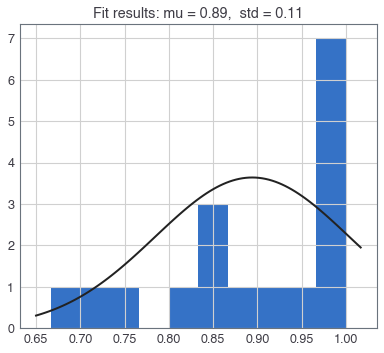

In [269]:

base_benef = pilot_user_ids[indices[2][0]]
neigh_benefs = pilot_user_ids[indices[2][1:]]

neigh_trans_df = pilot_trans_df[pilot_trans_df.user_id.isin(neigh_benefs)]
neigh_trans_df["user_id"] = base_benef

base_trans_probs = all_probs[all_probs.user_id==base_benef][['P(L, N, L)', 'P(H, N, L)']]
neigh_trans_probs = all_probs[all_probs.user_id.isin(neigh_benefs)][['P(L, N, L)', 'P(H, N, L)']]

from scipy.stats import norm

data = neigh_trans_probs.iloc[:, 0]
plt.hist(data)

mu, std = norm.fit(data[~np.isnan(data)])
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

print(norm.pdf(base_trans_probs.iloc[:, 0], mu, std), base_trans_probs.iloc[0, 0])

plt.show()


In [136]:
base_trans_probs

,"P(L, N, L)","P(H, N, L)"
2,0.571429,0.214286


In [150]:
from scipy.stats import norm
results = [[], []]
error = [[], []]
mus = [[], []]
for i in range(len(indices)):
    base_benef = pilot_user_ids[indices[i][0]]
    neigh_benefs = pilot_user_ids[indices[i][1:]]

    neigh_trans_df = pilot_trans_df[pilot_trans_df.user_id.isin(neigh_benefs)]
    neigh_trans_df["user_id"] = base_benef

    base_trans_probs = all_probs[all_probs.user_id==base_benef][['P(L, N, L)', 'P(H, N, L)']]
    neigh_trans_probs = all_probs[all_probs.user_id.isin(neigh_benefs)][['P(L, N, L)', 'P(H, N, L)']]

    if pd.isna(base_trans_probs).values.sum():
        continue
    data = neigh_trans_probs.iloc[:, 0]
    test = base_trans_probs.iloc[0, 0]
    mu, std = norm.fit(data[~np.isnan(data)])
    pdf = norm.pdf(test, mu, std)
    results[0].append(pdf)
    error[0].append(np.sqrt((test-mu)))
    mus[0].append(mu)
    
    data = neigh_trans_probs.iloc[:, 1]
    test = base_trans_probs.iloc[0, 1]
    mu, std = norm.fit(data[~np.isnan(data)])
    pdf = norm.pdf(test, mu, std)
    results[1].append(pdf)
    error[1].append(np.sqrt((test-mu)))
    mus[1].append(mu)
    
    print(i, results[0][-1], results[1][-1], len(data))
    print(i, error[0][-1], error[1][-1], len(data))



<ipython-input-150-2f2fb45f8de4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neigh_trans_df["user_id"] = base_benef
<ipython-input-150-2f2fb45f8de4>:22: RuntimeWarning: invalid value encountered in sqrt
  error[0].append(np.sqrt((test-mu)))
<ipython-input-150-2f2fb45f8de4>:30: RuntimeWarning: invalid value encountered in sqrt
  error[1].append(np.sqrt((test-mu)))


2 1.246582100914939 1.582332669783402 39
2 nan nan 39
7 1.5578562986558189 2.0421439944172852 39
7 0.34322628916283676 nan 39
8 1.7905991279220541 1.9340055941421848 39
8 0.1074889679015701 0.11363042132851013 39
10 1.0087859866222866 0.9635690972574148 39
10 0.4863998125577417 0.4655305838511332 39
12 1.5276056922051577 0.2329984864219135 39
12 0.28881908709584403 0.6212903520828461 39
13 1.5283843287643648 1.4813069898280926 39
13 0.3947575368404465 0.3722490498018781 39
15 2.460432772382543 1.73475791627114 39
15 nan nan 39
16 1.7296988751435398 1.1704236921687643 39
16 0.1705717028092624 0.4505085879795634 39
21 0.03074573089480978 1.3743074762243563 39
21 nan 0.4146137218260467 39
23 0.7569497484042221 2.150617244261761 39
23 0.5605433804768204 nan 39
24 2.130301015288542 0.021332744160909 39
24 0.26661766857295 0.7160391904551235 39
27 0.5051972834933374 1.9740793691774208 39
27 nan nan 39
28 2.6282861858506155 1.787885834309812 39
28 nan nan 39
29 2.210009375255116 1.76601323178

283 1.4912496092386835 1.561240459326808 39
283 0.36783821593758 0.35797415261110205 39
288 1.8092675862026908 1.3649181052816515 39
288 0.12688178953570986 0.41689211242781293 39
290 0.6289961198263129 0.8722617253722558 39
290 nan 0.47824154100279903 39
292 1.269087318462341 0.03316808027102057 39
292 0.41907102413264274 0.7591625865006167 39
293 1.6308293307191897 1.537229478623879 39
293 nan nan 39
294 0.6686082075589844 2.2869716285381263 39
294 nan 0.20657306330213526 39
295 1.8885229978604088 0.6048417153359864 39
295 0.17805787100219156 0.5606413863828336 39
297 0.8619015466022997 5.246368178309239e-06 39
297 nan 0.8767232116308548 39
299 0.012354732414772454 0.5494757303165573 39
299 nan 0.5055699359636843 39
303 1.6963496962608646 0.00025111609200834307 39
303 nan 0.7677060863500562 39
311 1.189436219468486 0.8390099891551832 39
311 0.44463697917180256 0.4803998278710986 39
312 1.2524755399057832 1.9605216846721452 39
312 nan 0.32942323728163103 39
315 0.11667009310140172 0.7

577 1.2504784185874658 1.622406426870789 39
577 nan 0.35563602579794745 39
581 0.23744762502954825 1.2969336212913676 39
581 nan 0.4307571614296616 39
582 2.1380046334662444 1.5739560593373065 39
582 nan 0.3910416534971614 39
583 2.0759778483872586 0.7483020186372724 39
583 nan 0.4867415863863553 39
584 1.6750341904594575 0.6071839841153159 39
584 0.22516084732474145 0.5852270014508778 39
590 1.1777491359060723 1.679943230625926 39
590 nan nan 39
591 1.4518079996577666 0.9739031836229146 39
591 nan 0.4702258235353543 39
595 1.2688164461021234 1.8156785177047803 39
595 nan 0.22836715518192657 39
596 1.1021320600664504 1.588648416602252 39
596 nan nan 39
601 1.230549317398364 1.2981593707351038 39
601 0.0737421426300344 0.42500859815199254 39
602 1.2206750098894719 1.8589483092468153 39
602 0.4373419176484133 0.3218182353356328 39
607 1.4548385687724665 0.6761779550521132 39
607 nan 0.5610190027886752 39
610 1.573727346014324 0.8806346187182795 39
610 0.3309394407000418 0.508194458522889

876 0.18475460622955556 1.790028800366025 39
876 nan nan 39
878 1.4377201794880354 1.2018514067280166 39
878 nan 0.4474655200721171 39
879 1.4059719469296095 0.02063348473148944 39
879 0.2728137677580299 0.7250532870993454 39
880 1.1312169656978814 0.022117018723637673 39
880 nan 0.7188047493999946 39
881 2.0721566995418725 1.3198030252455202 39
881 0.2575396996374671 nan 39
882 0.4198308584830317 0.015137916272759218 39
882 nan 0.743473492190257 39
886 1.4129027499592661 1.4180937019855342 39
886 nan 0.39231813303123736 39
889 1.5901290454996198 1.8540277141205692 39
889 0.35099900552105906 0.2327632979917328 39
892 0.9877036970118198 0.6961805272686553 39
892 nan 0.4879949116367064 39
893 1.3392881830561627 0.5195776162236335 39
893 nan 0.5598536286134879 39
894 0.13031639363730946 0.17168785016678723 39
894 nan 0.6165772355408982 39
896 0.6999062904704543 0.7174370709323664 39
896 nan 0.5050312058221431 39
897 1.0310916690768595 1.2218064853354438 39
897 nan 0.44501008184924057 39
9

1168 1.4738631130849436 0.8588682567181433 39
1168 nan 0.5066050406745897 39
1172 1.2738966390654896 1.6543687521361836 39
1172 0.4211920031359151 nan 39
1174 0.8035079898493525 0.6579886769154405 39
1174 nan 0.5501009343688114 39
1178 0.6551734495096797 1.6722997640636137 39
1178 nan nan 39
1179 0.7773917249012465 1.8718867535420725 39
1179 nan nan 39
1181 1.2767058976717627 1.175966701799498 39
1181 0.42765055982644906 nan 39
1182 1.6256411653215095 1.0369718682213112 39
1182 0.13383868566964366 0.4658108275046187 39
1184 1.7020937153758497 0.11802531876968565 39
1184 nan 0.7069214226901026 39
1187 1.299231984861835 1.0776161356962426 39
1187 0.3852438241369244 nan 39
1189 1.0099582757236034 1.4203312681751092 39
1189 nan 0.37151616637512314 39
1190 1.7072877671938802 1.1855233005160934 39
1190 nan 0.4517778594964683 39
1192 0.02716813805383345 2.110747831729276 39
1192 nan 0.24395909556539647 39
1193 1.5684830235926297 0.4607748642848134 39
1193 nan 0.5358901952025645 39
1196 1.5846

1456 1.795097371204043 0.04520587832439483 39
1456 nan 0.7260172835785926 39
1463 1.567498779888678 1.0719637262806423 39
1463 nan 0.47404958072142567 39
1464 1.695978892674914 2.2776844310011626 39
1464 nan nan 39
1465 1.5994620663275327 0.5418514300891616 39
1465 0.2417725534485387 0.5876599398147873 39
1466 1.8825211204404084 0.09407559958103827 39
1466 0.13108906679942223 0.704744232473513 39
1468 0.12689238014498397 1.9967563536454742 39
1468 nan 0.1934275058876767 39
1470 1.4475399156493096 0.1978735720891904 39
1470 0.32569157979016355 0.6161991047340306 39
1472 0.9275240517799355 1.98185769916371 39
1472 nan 0.24938737440033776 39
1476 1.772787613081389 0.9259716762738012 39
1476 nan 0.4986727974051996 39
1477 0.6132115394640996 0.7441749030686202 39
1477 nan 0.5356234686995888 39
1478 2.191512986443441 0.8100467567860925 39
1478 0.15428939336443168 0.514650509048076 39
1479 1.6912004990396996 0.22800235589603618 39
1479 0.3000260235909399 0.6548080533369995 39
1480 0.599682918

1732 1.5122546160677481 1.6884589101425076 39
1732 nan nan 39
1733 1.488261536936074 0.6149092424295458 39
1733 nan 0.5741999050834337 39
1734 1.5998241897062746 2.1239820768648476 39
1734 nan 0.2062310017525437 39
1736 1.9674417204053851 0.11707503434227629 39
1736 nan 0.5865159965022253 39
1740 1.0452460825015912 1.3961885967311443 39
1740 nan 0.4161776004253588 39
1741 0.9159386189492101 0.3439612419360377 39
1741 nan 0.6040349296156967 39
1742 1.6425646563026888 1.264689224114405 39
1742 0.35893730990095435 0.43266589701867264 39
1743 0.3360975698190165 1.0073000891565715 39
1743 nan 0.46661895621070715 39
1744 0.9686698832902328 1.9811739150074008 39
1744 nan 0.12305677335477788 39
1748 1.8582704409861632 1.0451751000266543 39
1748 nan 0.4551493847860423 39
1752 0.7994158963365608 0.8898953957131628 39
1752 nan 0.4941201946370233 39
1758 2.0068289427234927 1.5549543108599402 39
1758 0.26989412769893617 nan 39
1759 1.7753145905649534 1.2379048286465153 39
1759 0.3239130201543725 0.

1994 0.723647537159185 2.0524513829366766 39
1994 nan 0.16621250244867017 39
1996 1.4383822644335715 0.11576480974540555 39
1996 0.18745271532668767 0.6635346012235545 39
1997 1.405000181156159 1.7255838562665493 39
1997 nan 0.3337153663165527 39
1998 1.944253859133839 1.2098876527921787 39
1998 nan nan 39
1999 0.5176128074676477 0.8347819379698228 39
1999 nan 0.5190407953113751 39
2000 0.8702743871471806 2.133411246541989 39
2000 nan 0.28068689450388185 39
2002 0.9960651120416346 1.1688364425244013 39
2002 0.4803611480256773 nan 39
2003 2.802442196040647 1.195140480295192 39
2003 0.21989540041059394 nan 39
2004 0.43507227789376507 2.1321179846897764 39
2004 nan 0.2542797016378265 39
2007 1.6143692600964983 1.1243435532584842 39
2007 0.3015973265421231 0.46355032971515 39
2008 0.3711441482729383 1.577410029497813 39
2008 nan 0.3217103941759104 39
2009 1.999193209369174 1.784281658826155 39
2009 0.20678519874953089 0.3140073842747358 39
2010 1.1320983884038995 1.5625218177375846 39
2010

2236 1.8579989152043817 0.43017802216635737 39
2236 0.1862220235767123 0.6071545519098589 39
2237 1.3150005061308774 1.567451492219282 39
2237 nan 0.32935542809379387 39
2240 0.2791606711999027 2.120094761762864 39
2240 nan 0.2234015489446791 39
2243 0.039010359283600776 0.6899530006773674 39
2243 nan 0.541001917843182 39
2245 1.463499310843797 0.14358246488532453 39
2245 0.3100472037798823 0.6619327047232874 39
2246 1.266924221208577 1.4499806244514606 39
2246 0.43184786593904645 nan 39
2250 1.8967294373250738 1.3291809563143873 39
2250 0.20185218364856636 nan 39
2254 1.118838815531663 1.8434315024324315 39
2254 nan nan 39
2255 0.86680374538123 1.353952814298199 39
2255 nan 0.40678209737551907 39
2256 1.9552093803722945 0.3065109461896318 39
2256 0.17119727553152345 0.6458447411967746 39
2257 1.2223247332182077 1.07657592878893 39
2257 nan 0.47331768875780955 39
2259 3.0310885734859707 0.5854172597845327 39
2259 nan 0.5710384513898499 39
2260 1.882346675965865 1.6840177688288456 39
22

2551 1.613481474242203 1.0584821415511612 39
2551 0.31959340870525804 0.475524966309447 39
2552 1.5300250465198528 0.15952281552900027 39
2552 0.2618304007089788 0.6246619668015352 39
2553 0.29085795463012754 1.8360875377795889 39
2553 nan 0.2327753163730625 39
2558 2.1504761089566227 0.0007103602275934658 39
2558 nan 0.7933961940123869 39
2564 0.6862502675192279 1.9332742192609267 39
2564 nan 0.2519869820922335 39
2567 0.4947544289860006 0.8097531090680199 39
2567 nan 0.5100904782004952 39
2572 1.5004794827900934 0.2953836404187053 39
2572 0.28798036792061416 0.5633516814001402 39
2573 0.14267562311150125 1.811060710807592 39
2573 nan 0.2148034973273757 39
2578 1.7122673004261968 1.2104537287282104 39
2578 nan 0.44450795767934864 39
2579 1.1734059835835964 1.273427812144042 39
2579 0.4300745633873571 0.43589617581749124 39
2582 1.2532152531857583 0.08644391523644933 39
2582 0.36597809493631445 0.6914631768665086 39
2584 1.7999427760856341 1.6833454209479652 39
2584 0.29242585089738427

2790 0.9285622296252448 2.215111362608485 39
2790 0.49501832743008006 0.21751647499516447 39
2791 1.0047802217339736 1.5393994056227507 39
2791 nan nan 39
2795 1.3780954900543503 2.010371474938159 39
2795 0.37656314501797894 nan 39
2799 0.7812446413300846 2.3346271329019594 39
2799 nan 0.2548696636903327 39
2800 1.3155167179617067 2.0419899819705782 39
2800 0.3760675853478255 nan 39
2801 1.9436593970990959 0.13952813715051043 39
2801 0.13605684212656466 0.6977588827528487 39
2809 1.7715760056196108 1.4775255776185974 39
2809 0.3086424335877263 nan 39
2815 1.7361910288609625 0.94108313652738 39
2815 0.25901110616374107 0.5064425681291174 39
2817 1.1244968934788089 0.0668689678490801 39
2817 nan 0.7830674954576906 39
2818 1.579149406617549 1.8693574061036404 39
2818 nan 0.2549434364814661 39
2819 1.8631309737417965 1.4806930445670397 39
2819 0.31011480756396465 0.382600593944472 39
2823 0.8730911672343725 1.7354190219077386 39
2823 nan 0.2344267469181528 39
2825 0.44232412989229086 0.393

3105 1.242965044898427 2.219550428369452 39
3105 nan 0.28740206542243274 39
3107 0.02238581255173819 0.5537706486572979 39
3107 nan 0.5181566908426388 39
3109 0.011961114915617174 1.827460774167563 39
3109 nan 0.35561169193912695 39
3111 0.03507383740080135 2.0151548471856424 39
3111 nan 0.19096837297028513 39
3114 0.562946740609694 1.7996862424350493 39
3114 nan nan 39
3115 1.6515999328413917 2.0349788418167782 39
3115 nan 0.20133289427405532 39
3117 0.6264990476659824 1.4053574334731698 39
3117 nan 0.4083245147888089 39
3118 0.0020338433912842004 1.3429699085778999 39
3118 nan 0.38652270980799636 39
3119 1.2780846309630556 2.3676688760375884 39
3119 nan 0.1554965300927973 39
3120 0.5702048249651387 0.413543840738567 39
3120 nan 0.5936793256036371 39
3125 1.7849326024251606 0.5209641735738557 39
3125 0.14704588314933628 0.5756608788098585 39
3127 1.9637004522367827 1.216809093234412 39
3127 0.1919143264743636 0.43635328599858286 39
3128 1.8662483959369587 1.6400847979095419 39
3128 0.

3371 2.439838708104941 0.05686998065730094 39
3371 nan 0.7270030089845001 39
3375 1.9067439038354053 1.7488981838920223 39
3375 0.2057735902430388 0.35980493517063133 39
3376 1.6204440713238701 1.4266864047992271 39
3376 nan 0.40971463569239003 39
3377 1.5830492106789453 0.8651624631251156 39
3377 nan 0.5007848400239573 39
3381 0.738173560671829 0.6170884527630162 39
3381 nan 0.5332446762952329 39
3384 0.30989295506857406 2.768055822256587 39
3384 nan 0.07712748995945028 39
3386 0.6566691672591047 1.4715263463536934 39
3386 nan 0.4025974422445865 39
3387 2.0690039719287583 0.37860385594228463 39
3387 nan 0.576592398269137 39
3388 1.5991183822754986 1.0926444564175468 39
3388 0.3546544758749359 0.4669552717062566 39
3394 0.054342513468649795 0.4677417698841277 39
3394 nan 0.5799211548805968 39
3395 0.10858999053678971 1.2570837029711568 39
3395 nan 0.43635659066975113 39
3396 1.590018083471111 1.670004944303886 39
3396 0.3000742818626207 0.025285070890014225 39
3397 1.5856165909442916 1

3628 1.5073389502825483 2.2150734351252663 39
3628 nan 0.0306003269828511 39
3631 1.7652681163828774 2.0390331241976543 39
3631 0.08847868362026219 nan 39
3632 1.6628022508372637 0.012759507098024144 39
3632 0.24535614311515175 0.7376417452147673 39
3633 0.5234878955323176 2.3291027446758026 39
3633 nan 0.19338095891367618 39
3635 1.760163721406965 1.3222404572098219 39
3635 nan 0.4263793028552066 39
3638 0.8427171439075676 2.281350526464556 39
3638 nan 0.01820601220326065 39
3643 1.2754264423885742 2.438034767057539 39
3643 0.4354306351997139 nan 39
3644 0.08896258108871875 2.0042065695469997 39
3644 nan 0.1473692678115727 39
3646 1.181534915736842 1.802244659569357 39
3646 nan nan 39
3652 2.1497161425600786 0.19273447859414444 39
3652 nan 0.6902021367590943 39
3656 1.3633589383510487 1.8287460723877391 39
3656 0.4079407606860729 0.1962960548857772 39
3663 1.0174889862342915 0.5421870830583226 39
3663 nan 0.5792548180915497 39
3664 1.933645034448142 1.598245213410682 39
3664 0.2569661

3902 1.9438397075860017 2.123668745549197 39
3902 0.22700736580254313 0.30908289076100715 39
3903 1.2747651684626322 1.3586725566383113 39
3903 nan 0.419026085831573 39
3904 1.3552083663321197 1.5204665175103147 39
3904 0.31809000831075424 0.397236624076132 39
3905 0.9282754137390874 2.2612058811947153 39
3905 nan nan 39
3908 1.581749015391823 1.756091292286673 39
3908 0.26311111089565714 nan 39
3909 1.9342881404598722 0.3065181353196084 39
3909 0.3040376503108453 0.6266627010976991 39
3911 1.7040664806021308 0.09051963713728124 39
3911 0.2140466756662515 0.7080206022900429 39
3912 0.9385201612301891 2.4172983264535732 39
3912 0.5066281805128494 nan 39
3913 1.4117153013448638 0.9205727021017097 39
3913 0.365232837315936 nan 39
3914 0.1272127971385588 0.9212496423189211 39
3914 nan 0.49072284940862687 39
3915 1.0379086601272156 2.237143917114595 39
3915 nan 0.14115610904376408 39
3916 1.7851887010141632 0.01585907256105631 39
3916 nan 0.7068305321970916 39
3918 1.788246285703799 0.05134

4190 1.2291657858658411 1.7837590377005503 39
4190 0.4424149093944297 0.3279154778076756 39
4193 0.8502119833147207 1.832347677966028 39
4193 nan nan 39
4196 2.7157901763349836e-06 2.12679377900309 39
4196 nan 0.3038026480692615 39
4198 1.13907742098908 1.5523818054172205 39
4198 nan 0.3939680960315656 39
4199 1.272060617121141 0.6505398690104152 39
4199 0.42017362514453827 0.5753799582931138 39
4201 0.0988812111528691 1.841545956127482 39
4201 nan 0.14650476060764275 39
4203 1.7370283044573545 1.3321550819862016 39
4203 0.21266945759966369 nan 39
4204 0.6789175791085755 1.5273143868731367 39
4204 nan nan 39
4208 1.4116213494260996 2.1275222371266698 39
4208 0.13998054736951177 nan 39
4211 0.6521226976824511 1.7217070051492191 39
4211 nan 0.26147319895299126 39
4212 1.694004352679944 0.346741879363419 39
4212 nan 0.6139633715758008 39
4216 2.7411926072443684 1.3511719020016235 39
4216 0.16062716691679835 nan 39
4223 2.04202990111962 0.10603960577786173 39
4223 nan 0.6418188891848918 39

4488 1.4082263830162147 0.005911874070255944 39
4488 0.256482078930417 0.7937091504848728 39
4490 2.0859269496985196 1.9774630777796838 39
4490 nan nan 39
4496 0.13279159610592092 2.343319461593743 39
4496 nan nan 39
4497 2.1178663995753664 0.548728552607314 39
4497 nan 0.5947487004385844 39
4499 1.8705949587218504 1.2240602955388926 39
4499 0.19040550766611763 nan 39
4500 2.0635328346009114 1.2517182189921343 39
4500 nan 0.4391449211065871 39
4507 1.500154066201051 0.40994315608778326 39
4507 0.3759370710290888 0.5810263130306337 39
4508 0.9062500470385778 0.01618571807678164 39
4508 nan 0.765719135934333 39
4510 1.4779287511431045 1.8244341307525602 39
4510 nan nan 39
4513 1.3628419180689249 2.2534940219621307 39
4513 nan nan 39
4514 0.0309775362043944 1.4507798097798728 39
4514 nan 0.3976622432921671 39
4516 0.11453999549428745 0.40407641990369103 39
4516 nan 0.5883346819392161 39
4519 2.155811704343723 1.8363644106796582 39
4519 0.11849657247973598 nan 39
4522 0.6133811879387039 0.

4791 0.8911050820512644 0.4524131055579117 39
4791 nan 0.5654126016861373 39
4793 0.8004620360504907 1.3994741060047988 39
4793 nan 0.41217487222124793 39
4797 1.5713813742756484 1.6377157755554719 39
4797 nan 0.3793858371098711 39
4798 1.4301804345828226 2.038065450611174 39
4798 0.12193512949792519 0.23252891204443382 39
4800 2.292341973822696 0.9282021471625852 39
4800 nan 0.5017810422490152 39
4802 1.303042944388853 0.08967770149327683 39
4802 nan 0.70974988866059 39
4807 0.2547112244363728 1.9360879863489708 39
4807 nan 0.34084959476007254 39
4809 1.5725058124881386 0.16574247333358824 39
4809 nan 0.6794920934726599 39
4810 0.31627455040293484 1.6260738111852036 39
4810 nan nan 39
4814 1.7572207148405778 1.132662794540937 39
4814 0.33882973758709484 0.4590352992813871 39
4815 1.6141633956317893 1.706615766302743 39
4815 0.21519599292366315 0.21322597306102306 39
4817 0.1051007644214589 0.531583874883144 39
4817 nan 0.5271234321372784 39
4818 1.0336642388965727 1.87334155758964 39


5041 2.3162299921844416 0.07687726666153755 39
5041 nan 0.6900047810911678 39
5046 0.14708078548792783 1.6959051261950226 39
5046 nan 0.3579666497357066 39
5050 0.9120017610539306 1.6638672699761312 39
5050 nan 0.21291291237875842 39
5055 0.7374326771287576 2.0951148342493466 39
5055 nan 0.24938124040338783 39
5060 1.3882442665046737 0.8598099539818252 39
5060 nan 0.5025392791812701 39
5066 1.4180509256098752 1.8524308618735945 39
5066 0.2659416747560133 0.1909766450524602 39
5074 1.2936834378521493 0.2590396175286169 39
5074 nan 0.6115533489132117 39
5076 1.7386678613703856 0.7823216043800362 39
5076 0.23870520434166279 0.5022868677582172 39
5079 0.6896717437360661 2.2787243791328207 39
5079 nan 0.24949976576402344 39
5082 1.5065176318863884 2.002573397393945 39
5082 0.30523863597735107 0.22978516996439358 39
5084 0.25666399155721015 1.8504739028475006 39
5084 nan 0.3603606168090749 39
5085 1.1237583157790718 2.0692902106946396 39
5085 nan 0.18887521805633853 39
5087 0.071939406051141

5371 1.526098815448 1.6867052267733569 39
5371 nan 0.3452784094108518 39
5375 1.3342628874671114 0.05796266199062885 39
5375 nan 0.649641615412658 39
5378 1.9790255030441952 0.7013481485613401 39
5378 0.20105915375762257 0.5364091393751586 39
5379 1.2005905185777703 2.236158563989598 39
5379 0.38324933948839557 0.30492819533545706 39
5383 0.6842947460495845 0.8302658354975005 39
5383 nan 0.5274830215555375 39
5386 0.3743689051243971 2.3476696027652597 39
5386 nan 0.255822162055454 39
5387 1.9495586856892606 1.897881432690668 39
5387 nan 0.3238552827494194 39
5389 1.354734914018902 1.385098373009449 39
5389 0.3880255174738655 0.41235156160597697 39
5393 1.3112367910932559 2.3438237557112545 39
5393 nan nan 39
5396 1.5373340614380868 0.8744972561220128 39
5396 0.3633788522243427 0.49621654373216767 39
5398 1.4397251515198422 0.08978555133238059 39
5398 nan 0.667082618078551 39
5401 2.0851495583360404 1.8599923563385015 39
5401 0.2754331225371048 nan 39
5406 1.2202883709767745 0.922261199

5613 1.2985034696573876 1.3406026333108194 39
5613 nan 0.4163314965248025 39
5614 0.48657828764928285 1.8855363509711185 39
5614 nan 0.18208935853979186 39
5619 0.24830965484551215 1.7892047807984948 39
5619 nan 0.10435679605373571 39
5628 0.9185385948906015 0.18628793519713913 39
5628 nan 0.5956164277739402 39
5634 1.842070493019113 0.16394022098406918 39
5634 nan 0.6833599419170178 39
5635 0.031091023033053878 1.2709230723342066 39
5635 nan 0.43316183249074536 39
5637 1.7106263798066008 1.6631912708268037 39
5637 0.28092138169461023 0.34354099385280645 39
5639 2.4832602869617095 2.257136501896106 39
5639 0.226655195031283 nan 39
5648 1.444873098844153 0.808905506108791 39
5648 nan 0.5264447361167133 39
5649 1.1868134921993299 1.034044884589571 39
5649 nan 0.4801236173824179 39
5650 1.3848528679653134 0.5509590439351596 39
5650 nan 0.55216287406952 39
5652 0.8746532010946448 1.573503784804658 39
5652 nan 0.3773489882648304 39
5655 1.7924954209309814 1.7921755387810374 39
5655 nan 0.30

5916 1.3399889014752084 0.8683602396841069 39
5916 0.3827225357013645 0.5155704418767376 39
5924 1.0175293217834507 1.6430186718543045 39
5924 nan 0.31181550235991823 39
5925 1.5372851441817117 0.0013052056304067314 39
5925 0.18469971982570074 0.7759889876313406 39
5926 1.9716461289252472 2.010573008562802 39
5926 nan nan 39
5929 1.7619247928330086 0.6404585064737672 39
5929 0.18268080137805437 0.5724879003871413 39
5932 1.5619879198763538 2.695279558554617 39
5932 nan 0.1849568889043293 39
5933 1.7986470463833566 1.38727265761912 39
5933 nan 0.4120631938602721 39
5936 1.0506471823320238 1.5079957918690914 39
5936 nan 0.39729149866356844 39
5938 0.0007770406752366487 1.7156143996995945 39
5938 nan 0.2932025336956007 39
5948 1.3737931949498519 1.9041283064032393 39
5948 nan 0.3281852710092052 39
5949 1.5986431721546228 1.2463118396621071 39
5949 0.311138149508498 0.4353077691772453 39
5952 1.0617509939258318 1.6762383629721704 39
5952 nan 0.37631309565740517 39
5955 0.6909345654551012 2

6221 1.8762403816086426 1.8217329078386486 39
6221 0.23067650299083872 0.345718420865696 39
6223 1.9791904157032678 1.5577937801579225 39
6223 0.26936765113073974 0.34546725042778215 39
6224 0.7995260002022389 1.5333913698291146 39
6224 nan 0.3593414022565954 39
6225 0.5309109419008402 1.7036723685376454 39
6225 nan nan 39
6245 0.0473043269915769 1.8065502155066153 39
6245 nan nan 39
6248 1.7966893776917767 1.42873653054176 39
6248 nan nan 39
6250 0.24429742760109935 1.8634373031967415 39
6250 nan 0.15427783755001015 39
6252 1.4004989885270842 2.6590298762528435 39
6252 nan 0.0777568793469157 39
6259 1.462901874741081 1.3851144028071565 39
6259 nan 0.36821186332860134 39
6261 1.368722337600673 1.402894425806329 39
6261 nan 0.4113672317603678 39
6262 0.3978712139057673 1.3778685055678845 39
6262 nan 0.3931401309522611 39
6266 0.10211437700282665 1.871745765570141 39
6266 nan 0.2505593087861127 39
6267 1.366344735444853 0.08766534255711461 39
6267 nan 0.7022616296623728 39
6272 1.4108811

6528 1.6762630892522214 1.6389514202184288 39
6528 nan 0.1699258496819873 39
6533 1.5861418319597684 0.08992615178265932 39
6533 0.13781737524746102 0.6573768476440803 39
6535 1.7258684641915272 1.27039968349479 39
6535 0.24494442497410784 nan 39
6538 1.412562688351209 0.025728606258632377 39
6538 0.33372734906926754 0.7634020934241951 39
6542 0.0537223152079727 2.4384210629497582 39
6542 nan 0.17081152494587684 39
6545 0.3575067455679167 2.1308779143962724 39
6545 nan 0.29923066727036957 39
6547 0.002000775498739247 0.884871379772517 39
6547 nan 0.5100708192137804 39
6550 1.5256050609764034 1.3629921657002624 39
6550 0.3367215859419109 nan 39
6551 0.41202578288098146 1.9902617047367255 39
6551 nan 0.2521228524491918 39
6552 1.3463283283116358 0.012299577298605672 39
6552 nan 0.7360341601475978 39
6553 1.9541009101128277 1.917575123628837 39
6553 nan nan 39
6558 1.5486180006374348 0.14938919671333703 39
6558 nan 0.6271693157744229 39
6560 1.5387486468163891 1.9762571129670048 39
6560 0

6829 1.3662770150353998e-10 1.6933261785873173 39
6829 nan 0.36743234460737223 39
6836 1.309301896968943 1.0838680347485818 39
6836 0.17154126521262894 0.4631191822361188 39
6841 1.3101309022332308 0.7467110667659148 39
6841 0.4237535016870424 0.5358958557081114 39
6842 1.4243819116074672 1.1625973840367045 39
6842 nan 0.45568568587649344 39
6843 1.644796077158238 1.4546706379205416 39
6843 0.19106915663846374 nan 39
6845 0.6883642009915186 1.6097282520209872 39
6845 nan 0.3167443869212417 39
6846 1.5877920542336212 1.5870573088550002 39
6846 0.3826810217216695 nan 39
6847 1.6170446720219576 1.276062136000387 39
6847 0.33299280876056 0.43529370887660895 39
6848 2.5341367462704145 1.348366005875763 39
6848 0.192382178330409 0.4234023945999447 39
6849 1.2927836035496267 1.8174836474246296 39
6849 0.4131547458346178 nan 39
6850 0.04970908338308115 0.8154488600327315 39
6850 nan 0.5024940826114409 39
6851 1.7291356253866195 0.7440064355242576 39
6851 nan 0.5449614484774438 39
6854 1.063128

7124 1.175422549543086 1.0597765434486215 39
7124 0.42170928258124657 0.46914214640222424 39
7125 1.606382910226 1.5258353334054056 39
7125 0.161874256355216 0.2218209108480459 39
7127 0.252354372824993 1.865026967239239 39
7127 nan 0.31290359742743834 39
7128 1.687739711069069 1.2838652319628348 39
7128 nan 0.4333484926365877 39
7134 1.5046120592672148 2.5497605295863437 39
7134 0.21250511085740795 nan 39
7140 2.047878134310826 1.7014755440411793 39
7140 0.3179750274351806 0.3389560627063515 39
7142 1.3925965132305216 1.1275649423581378 39
7142 nan 0.45999964125942866 39
7146 0.1832420255613538 1.9485564608628487 39
7146 nan 0.3393980271259518 39
7147 1.7620550530534822 0.3843133704412696 39
7147 nan 0.5775258654462022 39
7157 0.34109495793352146 1.5249235456572203 39
7157 nan 0.39332583873869914 39
7158 1.4509846036245786 1.3192134367442843 39
7158 0.4036684922843068 0.4220273637834045 39
7159 0.2183829917536594 2.3512368071188696 39
7159 nan 0.2716776012021912 39
7163 1.079688390672

7435 1.4090249377589041 1.473317059262283 39
7435 0.2519950739431036 0.39896171500804506 39
7436 0.8304357528552286 2.247674422803219 39
7436 0.539503282180896 nan 39
7438 1.3743955273359652 2.1781197627814373 39
7438 nan 0.22260982091460468 39
7439 1.3780077271872135 1.6328624188081087 39
7439 0.28103866323467 0.37235567008681886 39
7440 0.23521908111747314 1.721968209037863 39
7440 nan 0.1436957960839645 39
7441 1.8084884639857628 2.0313293309840548 39
7441 nan nan 39
7442 0.5079824793516995 1.8145865084761634 39
7442 nan nan 39
7444 0.8684169968252758 1.6695623236353836 39
7444 nan 0.3187236789591071 39
7448 1.8057233872844412 2.8438519373738744 39
7448 0.2228905133247732 0.15465627123157905 39
7449 0.5585177992257172 1.3815216933611787 39
7449 nan 0.4184811385181118 39
7450 1.5879416651468206 1.382149357991009 39
7450 0.3683230263841686 nan 39
7452 1.8047000301524627 1.3927037070921202 39
7452 0.17286824705339418 nan 39
7453 1.5347765876123696 0.46177095312459904 39
7453 nan 0.6231

7641 0.9754650518668085 1.8657674302737277 39
7641 nan nan 39
7644 1.520103279081905 1.3481853967616804 39
7644 0.34800725521241377 0.42350372212368603 39
7646 0.7388104747415273 1.992058152654918 39
7646 nan nan 39
7649 1.6562569207134872 0.017482636308722505 39
7649 0.14737614339091734 0.7785810974995294 39
7651 2.33014407583985 0.046200148214104814 39
7651 nan 0.7623096466893601 39
7652 1.3705052189180373 1.7956166265256388 39
7652 nan nan 39
7654 1.3133382169461318 2.0593334886635235 39
7654 0.41964426461217974 nan 39
7656 1.3839081205982904 0.6963257015330794 39
7656 nan 0.497580930002872 39
7657 0.6229803586663101 0.6424128216031559 39
7657 nan 0.5479468064436456 39
7658 2.2777088048512444 0.04580092969319531 39
7658 0.19679492808632992 0.7667457303545574 39
7659 1.5376676005357985 0.4053238697830714 39
7659 nan 0.6249043541009439 39
7662 1.2799587351283535 2.041541950158015 39
7662 nan 0.18325529121544176 39
7664 0.5684119576126697 1.9705288964662455 39
7664 nan nan 39
7665 2.21

7895 1.669860497877423 1.6305538237613055 39
7895 0.33017163974753694 nan 39
7897 2.145754396995607 2.1784125942513257 39
7897 nan nan 39
7898 2.563101362380294 1.8796931896980078 39
7898 0.19603381149461976 nan 39
7903 0.5438564104215494 1.8208107149423827 39
7903 nan 0.2641033397166054 39
7906 0.03383412420301896 1.8722434181626306 39
7906 nan 0.338652272015209 39
7909 1.6175538245947028 2.360086186168762 39
7909 0.33679776454839044 nan 39
7912 0.6951055751019346 2.1424787263261873 39
7912 nan nan 39
7913 0.9444498489042238 1.6353186859105238 39
7913 nan 0.3339434364025756 39
7914 1.6969430437654411 1.963818048565236 39
7914 0.12183961777382414 0.19584632491954898 39
7917 1.7124386020058997 0.9014048198471257 39
7917 0.16653137745902713 0.5004674993956931 39
7919 0.8131764289060075 1.9235064523491638 39
7919 nan nan 39
7920 1.465839905037692 2.2593951608764065 39
7920 0.3504301642370167 0.2360802694390062 39
7921 1.7005641462839494 1.8618411241896147 39
7921 0.26790968464865217 0.033

8201 4.128998669894803e-06 0.6729286110496286 39
8201 nan 0.5234850237189143 39
8202 0.7944011450230934 1.5260381478574854 39
8202 nan 0.3707069488694857 39
8203 1.7604299385113198 1.57931593170131 39
8203 nan 0.37291670075198147 39
8207 0.9785563398898596 1.8872333754220265 39
8207 0.4829437822322472 nan 39
8208 1.4369830484502286 0.010316282974901142 39
8208 nan 0.6998886972982193 39
8209 1.9642599860840122 0.6107876863134737 39
8209 0.0509352616437254 0.5500366645965337 39
8211 1.8327045842098046 1.605206426289853 39
8211 0.19421092264841075 0.3499312649864943 39
8215 0.16787617621930154 2.3667594765217634 39
8215 nan 0.1087259858300425 39
8218 1.2989919613102276 1.2874035630107248 39
8218 0.41403783956064544 nan 39
8219 1.8529930335528715 1.559506494287253 39
8219 0.35485552492458455 0.10993562590664159 39
8223 1.2785547414761975 0.3010411564484843 39
8223 0.3365903214451113 0.61811367307708 39
8227 1.7389618045342254 0.6622453933732696 39
8227 0.22775703014164933 0.565785398658660

8456 2.065966433228349 0.052110037430253706 39
8456 nan 0.6826028853466861 39
8457 1.2873473254872352 1.4214187580475381 39
8457 0.4221523602580456 nan 39
8460 0.03539263644195826 1.8992699774058588 39
8460 nan 0.2821821885894433 39
8467 0.08409610078977807 0.9455520200047698 39
8467 nan 0.5057489461164906 39
8469 0.9802303020842008 1.6915586863369312 39
8469 nan 0.3330537279287677 39
8470 1.189697570689623 1.8792403371475614 39
8470 0.45072672908963585 nan 39
8472 1.5640133469189306 0.5298715937043428 39
8472 0.28237821931007145 0.5792477635367932 39
8473 0.041271882485562086 1.5278867735931727 39
8473 nan nan 39
8474 0.2751974513133463 2.0213518618441486 39
8474 nan 0.26965510795424347 39
8475 1.7188774086887184 0.0627408869319517 39
8475 0.19610121096020777 0.7163127074400801 39
8483 1.3391695196345792 1.9626261710332749 39
8483 nan nan 39
8484 1.657634230005251 0.6129694611578447 39
8484 0.29357378671194695 0.5518068532687255 39
8486 1.7236377433693864 0.19105877380477063 39
8486 n

8697 nan 0.6984263625121946 39
8699 1.277860913641022 1.9394517535507838 39
8699 0.37841440456173786 nan 39
8701 1.7830845594802585 1.3675350922889535 39
8701 0.3571530928195652 nan 39
8703 2.190960650261201 0.8623893701950556 39
8703 nan 0.5080918016273861 39
8706 1.6472380226043863 1.678308200717811 39
8706 nan nan 39
8707 0.2728013189200305 1.6281935496077249 39
8707 nan nan 39
8708 0.6885461048351947 2.037123243474608 39
8708 nan nan 39
8715 2.328936749052535 0.04170129984607737 39
8715 0.1472276426810003 0.7756941995239977 39
8716 1.3042904471092818 0.84141815639726 39
8716 0.4232673320193921 0.523004726024341 39
8719 0.23520387011455246 1.6429815525439424 39
8719 nan 0.25815968476337453 39
8720 1.50348046018333 2.095749073849417 39
8720 0.07365534617865992 nan 39
8722 1.829734686094303 0.6243995972001871 39
8722 nan 0.5625170103570738 39
8725 0.7858479934067216 1.6785745598860309 39
8725 nan nan 39
8726 1.2524428501381681 0.013033244582933232 39
8726 nan 0.7227370852315649 39
873

8963 3.4452109639753514 0.36131946598835557 39
8963 nan 0.6083605727602185 39
8965 2.0224379044421257 0.8535756231028516 39
8965 0.13087542743743327 nan 39
8975 1.1754033539467181 0.21729905643536598 39
8975 nan 0.6132569228756564 39
8980 2.049901096570182 0.3583007489911369 39
8980 0.2866542273126147 0.6180747239224625 39
8984 0.6399178007702444 2.5929335000803806 39
8984 0.5388479775012085 nan 39
8994 1.5283843287643648 1.4813069898280926 39
8994 0.3947575368404465 0.3722490498018781 39
9004 2.049901096570182 0.3583007489911369 39
9004 0.2866542273126147 0.6180747239224625 39
9015 2.3159413804876787 0.5725225815085571 39
9015 nan 0.5583220500000702 39
9019 0.9238596461811585 1.0868597932418826 39
9019 nan 0.46834140802558066 39
9020 1.5064872121954251 1.3579506310380842 39
9020 nan 0.3584099960058485 39
9021 0.01733173687463514 1.6006329891409534 39
9021 nan 0.1734715361994544 39
9023 0.4875723084682446 0.654897841960599 39
9023 nan 0.5437244119508465 39
9027 1.7582677500955224 0.153

9219 1.8317206427135986 1.816340947886171 39
9219 nan 0.10327039180069261 39
9220 0.46213149739634635 2.3830295918739166 39
9220 nan 0.14470183536472297 39
9222 1.5999129614202403 2.087615245656342 39
9222 nan nan 39
9234 1.3654553813383914 0.48136112081452925 39
9234 nan 0.6269252969190603 39
9237 0.9299739488951921 1.9779668943637385 39
9237 nan 0.21306321835506492 39
9239 0.9561874099290871 2.2464188106657206 39
9239 nan 0.21405490597111676 39
9242 0.3447561872133359 2.16312949457358 39
9242 nan nan 39
9244 0.03598743132791236 1.965190570494274 39
9244 nan nan 39
9245 1.76202251545504 1.2620371972910933 39
9245 0.3158402649589798 0.4375587767800455 39
9246 0.44780593526657336 1.6013672675289523 39
9246 nan nan 39
9247 0.32063171182691486 0.3031505057000545 39
9247 nan 0.6054147923822313 39
9248 0.45629922850060195 2.3337319572704183 39
9248 nan 0.15123904876198563 39
9249 1.5397736954409462 1.568817313211613 39
9249 nan 0.38821883762144327 39
9254 1.5441560624627262 1.27028996394710

9471 0.8119415693002762 1.9353543681227883 39
9471 nan 0.2382296011122073 39
9476 0.44591065069096014 2.346197477175162 39
9476 nan 0.2338840764510953 39
9481 0.05846925956969323 1.4776756799158968 39
9481 nan 0.3923763941323133 39
9483 0.40372332242886055 1.3774421276345814 39
9483 nan 0.4141069382395721 39
9484 1.3712337960393375 1.6100629191536233 39
9484 0.39278590205176384 0.35834487314483865 39
9485 0.1563471238331427 2.39409266770721 39
9485 nan 0.2219653728048556 39
9486 0.1677305934036259 0.6019673235597752 39
9486 nan 0.5101046956449019 39
9489 1.405172183942518 1.736925111513382 39
9489 nan 0.23023443807739652 39
9490 0.4492529616891307 0.046261887734027785 39
9490 nan 0.6991913480477512 39
9492 1.724661719607707 1.6690653374198041 39
9492 0.15841671962350662 0.06625727989736893 39
9494 0.02093183633774939 1.5399006923081684 39
9494 nan nan 39
9495 1.0195048381782796 1.9607446864189586 39
9495 nan 0.25865131769260075 39
9498 1.6558397037639179 1.5901429608542367e-05 39
9498 

9720 0.2864958892575129 2.284632955655897 39
9720 nan 0.2502122908794036 39
9721 0.8052158216584051 0.9507067399768883 39
9721 nan 0.49966814867836257 39
9723 1.0783685286075553 0.9729997351879501 39
9723 0.4235920125898072 0.47829962768403866 39
9724 0.2084310431211377 1.3213262859026662 39
9724 nan 0.4276561996308153 39
9725 1.5989978188948752 1.3704916719552327 39
9725 0.27705837286801865 0.42002275190508187 39
9726 1.170667041685267 0.4151296316468878 39
9726 0.4544824780242477 0.6021038657070469 39
9736 1.7157776478570876 2.5513063434278336 39
9736 nan 0.20329367882448204 39
9744 1.946440438282705 1.1818610176630513 39
9744 0.23117427150670408 0.43265515949785127 39
9746 1.1033639436107732 1.1362498356657216 39
9746 nan 0.46005156804644887 39
9747 0.5835076693049984 1.8714133521561183 39
9747 nan nan 39
9748 0.5714225886099067 1.3363602900795553 39
9748 nan 0.4230779385460416 39
9752 0.8633755367450661 2.248403655075195 39
9752 nan 0.20151275132489072 39
9754 1.318742989950762 1.4

9973 0.320257672729576 1.4322155212306331 39
9973 nan 0.41061093467073073 39
9974 1.8742668223748 0.15468859117197917 39
9974 nan 0.6787141849076166 39
9977 1.6957177707530697 0.2373056116450032 39
9977 nan 0.6538011007569702 39
9978 1.1707212156237266 2.0535391883297267 39
9978 0.4462308331737035 nan 39
9979 0.7215492697026719 1.8245053211120303 39
9979 nan 0.28207922851079753 39
9981 2.4414596369827515 0.018519328362310062 39
9981 nan 0.6957412611375815 39
9985 1.8433110870490588 0.9094727744841109 39
9985 0.17974224091406127 0.4993763258189955 39
9986 0.5511002950880722 2.075116793284079 39
9986 nan nan 39
9987 0.9991746169805874 1.7103372872479323 39
9987 nan nan 39
9989 0.14642107895112413 0.15271340786993717 39
9989 nan 0.6621083185709998 39
9990 0.43276786489999575 1.498370679171679 39
9990 nan nan 39
9991 0.009818069974433677 1.8002649508543291 39
9991 nan 0.34456716374343554 39
9992 0.2873755500376801 0.012520484614684455 39
9992 nan 0.8170039887882099 39
9993 1.21095750684559

10219 1.679392042505677 0.2590000852425044 39
10219 nan 0.6254802990190007 39
10220 1.4772415928960931 1.329137137410456 39
10220 0.3414801908048787 0.387623887617242 39
10221 1.4544081173270738 1.5372839642465868 39
10221 nan nan 39
10223 1.8611032333878033 1.8129563653114635 39
10223 nan nan 39
10228 1.939224239151864 0.5807017423577133 39
10228 nan 0.5747098156127777 39
10229 1.3298191424912813 0.7557502269081918 39
10229 nan 0.5097928350646231 39
10231 2.106121831029049 1.7185560438916094 39
10231 nan 0.14998164697978514 39
10233 1.461926480473251 2.0116268649320994 39
10233 0.2949558633426844 0.12865645050323346 39
10237 1.6805962013785871 1.2888366753650848 39
10237 0.3226826231316682 0.4313592919942773 39
10238 0.3966541122415002 2.436460031814458 39
10238 nan 0.22010920669833972 39
10243 1.5206491631434322 1.2032582789840685 39
10243 0.3254517666098014 nan 39
10244 1.5895467267368781 1.8381174715107549 39
10244 0.32254475398126176 0.3041011060009172 39
10245 1.0411949100137197 

10437 1.7419766196883897 0.4871061985323519 39
10437 0.20622907780047056 0.5851901768029808 39
10438 1.9729725371652445 0.10596108417816764 39
10438 nan 0.7361701435642907 39
10439 1.4705971133256541 1.5263938283675964 39
10439 0.1966381693410563 nan 39
10440 1.3540283232295687 1.455762394971537 39
10440 nan 0.40665795749150446 39
10441 0.025776530808467275 1.4639917686949047 39
10441 nan 0.400678849070868 39
10442 1.48684816476382 1.7121735025409093 39
10442 nan 0.0726020164947924 39
10444 1.3162002593226156 1.5407498230363872 39
10444 0.4111987515807579 nan 39
10446 0.3456746553380166 1.9698390797129657 39
10446 nan nan 39
10448 1.2181207892217383 0.3316328655249864 39
10448 nan 0.6367809971129446 39
10449 0.15430380078029549 1.8597320180437622 39
10449 nan 0.26191857693558546 39
10454 1.5340896784465798 1.7950520592515458 39
10454 nan 0.3201007577974687 39
10458 1.8376961869177248 0.5718771537012032 39
10458 0.21649357264857408 0.5952301988260019 39
10460 1.8194023505813055 0.767835

10702 1.6797874963219568 2.127387237480718 39
10702 0.2810109491392091 nan 39
10707 1.091572383647312 0.316717078039335 39
10707 nan 0.6266573316402534 39
10708 1.619986546307165 1.0281865864627662 39
10708 0.2797875928768936 0.47568236373111233 39
10709 0.6267973105293355 2.5395457180474037 39
10709 nan 0.10958545678656802 39
10719 1.6548110349540985 1.8910737744710142 39
10719 nan 0.24026445136502203 39
10720 1.639480024267791 0.9601757424450215 39
10720 0.28897380697952585 0.496737915729268 39
10724 1.8280867639079714 1.0171446290343202 39
10724 nan 0.47316127672096664 39
10725 1.6649459425420008 1.7065708735063418 39
10725 nan 0.3418716935866915 39
10727 1.3972342018748678 1.5749997315505337 39
10727 nan 0.387176280046448 39
10732 2.4611166688319583 0.7809800181875797 39
10732 0.22337675078565766 0.5145924831985035 39
10736 1.3040165871793798 0.8679886587947637 39
10736 nan 0.5177335959253825 39
10737 1.7160443418060705 1.9688688371565566 39
10737 0.3064728676164683 nan 39
10738 1.

11016 1.604936114222367 0.2981865995813721 39
11016 0.2921557181774595 0.6126411099885601 39
11021 1.6218117834811787 0.351742914941453 39
11021 0.28031874656172073 0.594202741747804 39
11023 0.8187607491385772 0.9856027880112199 39
11023 0.5411654133245718 0.4834461167397151 39
11024 1.5641915768891796 0.6120694762944355 39
11024 nan 0.5761621285802867 39
11025 0.7856114209195951 0.5134167992275368 39
11025 0.5527707983925667 0.5236297951652072 39
11026 0.9295270419591867 2.5247695687547083 39
11026 nan 0.1487883386680838 39
11027 1.5496394574550656 1.5483769544492845 39
11027 nan 0.3327070266535393 39
11028 0.4112542573399915 0.057316816757246765 39
11028 nan 0.7125382062089334 39
11031 1.364159711553014 0.20855116143336036 39
11031 0.40275593083990585 0.604612268047959 39
11033 0.755254633663134 1.9761140071753187 39
11033 nan 0.3452660449429952 39
11037 1.658774620347956 1.1627631331823354 39
11037 0.25741878264720724 0.45605689491314333 39
11040 1.7265911633991935 0.43470488410536

11278 1.8588902572775206 1.7633945683584822 39
11278 0.3339850783409883 nan 39
11279 1.9428450656321783 1.3765193985101893 39
11279 nan nan 39
11280 1.7012452333991428 1.4120703969842994 39
11280 0.2756291079296083 nan 39
11282 1.268255382279119 2.429658163551142 39
11282 nan 0.2210786618348825 39
11283 0.6812860596507574 1.1503797124337098 39
11283 nan 0.44086440214322975 39
11286 2.049901096570182 0.3583007489911369 39
11286 0.2866542273126147 0.6180747239224625 39
11287 1.2131142302245326 1.5273303625313972 39
11287 0.44428495272712987 nan 39
11290 1.119845372663036 0.8111386772604446 39
11290 0.4179858149178296 0.5151875619955824 39
11292 1.56475737874061 1.565076359426562 39
11292 0.3576931962314232 0.3604532335988261 39
11296 1.9507959493136298 1.118581742383005 39
11296 0.3178143181763113 nan 39
11297 1.5283843287643648 1.4813069898280926 39
11297 0.3947575368404465 0.3722490498018781 39
11300 1.450908507969536 0.8865399782219456 39
11300 0.36979614802497707 0.5027423781158562 3

11539 1.514489565887985 1.2925149752813625 39
11539 0.19628355416572538 0.4290409560490282 39
11540 1.3460237391530332 2.0043539016072978 39
11540 nan nan 39
11541 3.741089568861065 1.6021625086553044 39
11541 nan 0.35387955964762763 39
11548 0.36876533467349426 0.45604197042042155 39
11548 nan 0.5534254823142476 39
11551 1.7482270533726119 1.420578448383625 39
11551 0.28330083043033705 nan 39
11552 0.6168438913556676 2.000962127016695 39
11552 nan 0.06397211771180261 39
11553 0.1026870842807964 1.7742381283538007 39
11553 nan 0.2848711233832668 39
11557 1.3320495464011313 0.5304604230066688 39
11557 0.30731973628225 0.569358654051323 39
11558 1.658919770358751 1.625519034885207 39
11558 0.28194337798417457 0.368715366321012 39
11559 1.3182823775905983 0.9564667840972579 39
11559 nan 0.4868684126935216 39
11563 1.707404097154748 1.2279454220973853 39
11563 0.23674939200861944 0.4430158285211713 39
11573 0.08901083042176122 2.127821521113744 39
11573 nan nan 39
11575 1.1654467360570395 

11812 2.1503340049303423 2.0752485417957 39
11812 0.10418646895531337 0.24606578545104946 39
11813 0.006678405438204639 1.4729654522649986 39
11813 nan 0.38591727831506023 39
11814 1.8083011707818364 1.2780740484659456 39
11814 0.23527526144073485 0.43473068501905 39
11815 0.954333843337167 1.676271232342326 39
11815 0.5013013219398543 0.18210991952102124 39
11816 1.1892928640765363 1.7009030883460161 39
11816 nan nan 39
11817 0.271386631600638 0.14802678164918187 39
11817 nan 0.6398265062543953 39
11819 0.7094521000658476 1.128677727914203 39
11819 nan 0.461837261391739 39
11821 3.2061318612756664 2.102337324312122 39
11821 0.1860092649387582 nan 39
11822 2.0030262142166633 0.640727740118624 39
11822 0.22834352784517767 0.548222560228668 39
11824 1.03584241906148 0.7595413945514211 39
11824 nan 0.5293472261470875 39
11827 1.6235995296800965 2.303274620565023 39
11827 nan 0.1728769801945509 39
11831 0.5158242987455638 1.979874306322683 39
11831 nan 0.2356552008917768 39
11833 1.5958084

12073 1.0739989894678 1.4657777870788413 39
12073 nan 0.39859285472379025 39
12076 1.7052942386258743 0.32054939938391735 39
12076 0.21702791156871037 0.6238667488373791 39
12079 2.156631132944963 0.592340550255121 39
12079 nan 0.5590775445606985 39
12080 1.5306281920105411 0.8937261485142445 39
12080 nan 0.520219517567841 39
12081 2.025834167307425 1.4908308258947784 39
12081 0.3099327027546129 0.38644287966543556 39
12082 0.02631981328380103 1.6365738794000277 39
12082 nan 0.3807387468166334 39
12084 1.351970964123487 1.4810980241940281 39
12084 0.4041766003944771 0.39789335374689533 39
12089 1.7611071613522071 1.9695994665385763 39
12089 0.3348446641813975 0.07710145661637384 39
12092 0.08639721641893933 1.694597618686755 39
12092 nan 0.19526189440006222 39
12097 2.327637108211093e-05 1.7164065774247679 39
12097 nan 0.2737705057007074 39
12099 1.612052380640567 1.307406787738507 39
12099 0.2530920191249114 0.4041326946692563 39
12101 1.509412995405305 0.8690744098210383 39
12101 0.3

12379 1.2806516407200148 1.5345306696947174 39
12379 nan 0.38648276832555345 39
12380 2.4256648384045816 0.15164272105547735 39
12380 0.13002919410407818 0.6046864928689399 39
12386 1.2369956824017767 2.541382858554046 39
12386 nan 0.27401909284638903 39
12388 0.12871086435980406 0.8272203896867291 39
12388 nan 0.483572101387522 39
12390 1.4318274049905446 1.981287656619251 39
12390 0.19098690209046923 0.33426222404719136 39
12391 1.1026337683851324 0.13617116020101389 39
12391 0.4048158850485805 0.6001872453970154 39
12392 1.509469377127419 1.0200539193257736 39
12392 nan 0.4782981092312995 39
12393 1.6289383244475275 0.9483491432496828 39
12393 nan 0.4974307822774917 39
12397 1.6048022592530375 2.0659803558266874 39
12397 nan 0.19318200976860195 39
12399 1.698448764282937 1.4027654912742669 39
12399 nan 0.37882397031816417 39
12402 0.3439063851574608 1.366715128313408 39
12402 nan 0.4202727759508634 39
12405 1.496501511186824 0.022519625664670057 39
12405 nan 0.6804203569552932 39
12

12636 0.6151262071140867 2.400424356849538 39
12636 nan 0.18981321177060273 39
12637 1.4617937911245293 2.29826103495627 39
12637 nan nan 39
12639 0.19585840821688566 1.5722733259295802 39
12639 nan 0.337868406992143 39
12640 0.44908056117716794 2.0820787990999503 39
12640 nan 0.3161604353648372 39
12641 3.4481857026448743 1.8495917998146905 39
12641 nan nan 39
12642 0.4954810805198467 1.706853809067637 39
12642 nan 0.3297430294813357 39
12644 1.4165102573633572 0.32770767364654646 39
12644 0.2755765960989074 0.6329730047344969 39
12647 0.9897757092298716 2.0266991390812428 39
12647 0.49343373730100204 nan 39
12649 1.8922453076668564 0.11240672047191798 39
12649 0.2671721341348816 0.6469247831755655 39
12654 0.8166906391626836 0.6597814840067063 39
12654 nan 0.5384061768998715 39
12655 1.2729921877029058 1.1011753363334065 39
12655 0.41778593941052167 0.4459305224091586 39
12658 1.2638357806251908 1.059474667050696 39
12658 nan 0.4718228064434599 39
12659 1.5651362639334243 1.981967467

12895 1.7765212800787957 1.3737490824499352 39
12895 0.15484824347031603 nan 39
12896 1.0205298583653053 1.5469365252963299 39
12896 nan 0.3772704410006484 39
12899 2.091362001377949 0.6846956109660838 39
12899 0.08814000025864868 0.5244027943259878 39
12900 1.649047018373667 1.3337523351427563 39
12900 0.383057951303616 nan 39
12902 1.8304102852136195 0.10194664614175046 39
12902 0.11186472732545985 0.6602746975548027 39
12906 1.3728885424646136 1.7105795887596151 39
12906 nan 0.3277591764999167 39
12907 0.5681903562431438 1.6079541498576582 39
12907 nan nan 39
12909 1.6762935817199185 0.43981904321683785 39
12909 nan 0.5353900025914254 39
12912 0.7073800425426299 1.9516567060624133 39
12912 nan 0.17514970981334646 39
12913 0.5489048120399186 1.7183168936246782 39
12913 nan 0.34967867507840333 39
12916 1.1928181060503333 0.30828939026874624 39
12916 0.3928632071003262 0.5784263923808709 39
12919 0.31209696496548006 2.1228807274625274 39
12919 nan 0.23868513776277386 39
12921 1.6286779

13109 1.1916534859166177 2.2988768658699312 39
13109 nan 0.23847356791451682 39
13110 1.101151314119834 2.3846659021059713 39
13110 0.4684335340761678 nan 39
13113 1.4019166390387017 2.061229878829109 39
13113 nan 0.05151619221563495 39
13115 1.7013726482088882 1.5735198491837015 39
13115 0.35193350020006753 0.2074796825594769 39
13116 1.3569590986221396 1.994104538632297 39
13116 nan nan 39
13118 1.8262873959066035 1.3350786923403997 39
13118 0.22310175166108528 0.4132752134196439 39
13122 1.5341741828069033 0.06856298227603057 39
13122 0.13321658519188959 0.6771091583428972 39
13123 1.6219282626557874 1.85270946304156 39
13123 0.3635935697447601 0.20381463824022794 39
13125 0.005578154153160424 2.0018394963574417 39
13125 nan 0.18056736226678172 39
13126 0.9759954649274655 2.324147282945496 39
13126 0.49513207344684323 0.1581094362976525 39
13127 1.5583951483303808 0.6437584618977225 39
13127 nan 0.5119234410768018 39
13128 1.5432444890322796 1.4908827303754455 39
13128 0.26225286205

13367 1.3721013366548507 1.7854960116004404 39
13367 nan nan 39
13370 1.6830252921577176 1.2362708495720038 39
13370 0.26322566275930553 0.43887532283494785 39
13374 1.3108672509933625 0.2828037202535229 39
13374 0.4101791223372103 0.6084801106973462 39
13375 1.3063779310212773 2.219389506449251 39
13375 nan 0.3180262344161385 39
13381 0.2107391768793364 1.5444529189771947 39
13381 nan 0.391330812732491 39
13382 0.9555223212265875 2.5025203006906884 39
13382 nan 0.24672643793482343 39
13385 1.3370130596807221 0.24321046352035847 39
13385 nan 0.6333018436821671 39
13386 1.4330852662672662 2.1664680854977267 39
13386 nan 0.29218489941868864 39
13390 0.3986654997716534 1.9750970027224466 39
13390 nan 0.15641087752064284 39
13392 1.273601325010701 1.1697126461498313 39
13392 nan 0.4369534818822857 39
13395 1.5653653759953405 2.5948036463148814 39
13395 nan nan 39
13398 1.806510037966668 1.8521573343081341 39
13398 nan 0.2584846954199613 39
13402 1.087102978881421 1.1158731943306714 39
1340

13686 1.8708173446659109 1.1667665017966384 39
13686 nan nan 39
13688 1.4535865687380956 0.6454510705420569 39
13688 0.27340975222189035 0.5283895130358296 39
13694 3.6050650239958295e-05 2.0322985884718134 39
13694 nan 0.20029071367587417 39
13700 2.437739137230268 1.8675210107804907 39
13700 nan nan 39
13701 1.1981714456902026 0.41995114706495285 39
13701 nan 0.5666816291297853 39
13702 1.4134440165230497 3.436939374481363 39
13702 0.18069355920359303 nan 39
13708 1.3809619780133864 0.6826670951690186 39
13708 0.38247549172022655 0.5479521636936474 39
13709 1.9913001332194529 1.681087122601805 39
13709 0.21339054814675412 nan 39
13713 1.7195151118086427 1.6529141734252049 39
13713 nan 0.3739943070510063 39
13717 1.424744086402048 1.6167576936286445 39
13717 0.1356036831367252 nan 39
13719 1.5004459246398505 1.8093928899108975 39
13719 nan 0.3261496172325536 39
13722 2.487010104299587 0.4452655464103799 39
13722 0.24050856891813258 0.5079934023246383 39
13725 1.7720796398536796 1.3655

13948 0.47342361636050867 0.4948065987025729 39
13948 nan 0.5437297431565858 39
13951 1.4073031482017417 0.9865302112673097 39
13951 nan 0.4944811202139404 39
13953 1.8623067302806584 1.079080266113768 39
13953 nan nan 39
13955 0.5456180506992913 1.2940957620177593 39
13955 nan 0.419754959840054 39
13956 1.6225257556967971 2.1173797252908133 39
13956 nan nan 39
13959 1.0758156604752984 1.9643156445870908 39
13959 0.47350224939132535 0.2828357308606909 39
13960 1.635765934543879 1.112161938986528 39
13960 0.18256567748069122 nan 39
13961 1.058108742163339 1.6498379346156142 39
13961 0.4748840256641766 0.37120466037753386 39
13962 1.7126019123418128 0.02070877431202266 39
13962 0.29911102887123314 0.6869364192568165 39
13964 1.0576135452284863 1.140769548155084 39
13964 0.46909928157571495 0.46041270234920806 39
13965 0.9617593982445718 1.2494059253441805 39
13965 nan 0.4395943524589266 39
13967 0.07293746421383508 1.5551498755984339 39
13967 nan 0.36150573992509977 39
13971 1.4517966166

14192 2.1051353720777626 1.8379655780050441 39
14192 nan nan 39
14197 2.1032747181160434 1.0393601964095112 39
14197 nan 0.4797435750653014 39
14198 1.2382381306804702 0.4148053514484852 39
14198 nan 0.5475994509162208 39
14199 1.736412929447625 0.9678266665243727 39
14199 nan 0.4961330826376219 39
14200 0.6561265634178897 1.854653910388198 39
14200 0.5420659597991786 nan 39
14205 1.5448540713099772 1.6430121671226365 39
14205 nan 0.3532766159901761 39
14209 0.39151131414340945 2.1982149039265177 39
14209 nan 0.3071416567610299 39
14211 1.9210710278996461 0.44659666319035196 39
14211 0.21004599549208622 0.5838092517284227 39
14213 1.5927748841273395 0.8299654811839554 39
14213 0.2956871343895208 0.5153916106215647 39
14215 1.1055953615801728 1.3487493735421612 39
14215 0.42678197846541865 0.3930733056454372 39
14216 1.770945182524273 0.8869320488431693 39
14216 0.33031963342598775 0.5141317513335376 39
14217 1.3612427368734066 0.8117580864603924 39
14217 0.39052036307565613 0.526128872

14441 1.0490999979740296 1.801506036085468 39
14441 0.4614791034954486 0.3660686072926914 39
14442 0.006744364378568934 1.8688008036723178 39
14442 nan 0.3229425377146607 39
14443 0.0010588085298695053 1.915020603224286 39
14443 nan 0.19021939369203475 39
14446 1.73093265961707 2.112605269354863 39
14446 nan nan 39
14447 0.876897224496116 1.8257844493182804 39
14447 nan 0.36361076630406874 39
14450 2.3454467985977696 0.5523448953149381 39
14450 0.09529253877043943 0.5712786237459347 39
14454 2.0822866707224463 1.7098734443355867 39
14454 nan 0.35735401052225874 39
14456 0.584175241842561 1.2669946485965415 39
14456 nan 0.43364468965687103 39
14463 1.0807473954288227 1.7965059334700944 39
14463 0.46843240456143015 0.12349315448615744 39
14464 1.6858147428811008 0.7256770877722841 39
14464 0.30267378687041946 0.5318589307076246 39
14467 1.6839947976863299 0.29184621782573833 39
14467 0.27854616847678304 0.6059739585190677 39
14469 0.4946814416958525 1.4841930536760293 39
14469 nan 0.3342

14714 1.3266849538294265 0.2349418153349666 39
14714 0.25406534428537536 0.6165761129847714 39
14718 1.1994946460804348 2.7061385599278474 39
14718 nan nan 39
14719 1.9129017190620887 2.2444219566406853 39
14719 0.21269940570256515 0.24317747511367924 39
14721 1.4488655241832433 0.3230251641412847 39
14721 0.258441227869039 0.5936385534381121 39
14722 1.1542511468584766 0.18520354510684944 39
14722 nan 0.6395092769471888 39
14723 2.2049999931345767 0.9726655390753481 39
14723 nan 0.4793923705083669 39
14727 0.33964617400909575 1.9991670786076412 39
14727 nan 0.21368255726231794 39
14728 1.5173221652031572 1.9973752494423809 39
14728 0.3663176292674637 0.1536426451928365 39
14729 1.4654345478460808 1.5435478784925294 39
14729 0.3080233439242513 nan 39
14730 0.5153789336164196 1.8686368848947472 39
14730 nan nan 39
14731 1.6163191454956447 1.346785888858352 39
14731 nan 0.4199609605256308 39
14739 0.3069849381126708 1.796773007357093 39
14739 nan 0.2501839591360864 39
14740 0.01718938525

14986 1.481967800879679 0.6728060834442477 39
14986 0.32714460392391176 0.4970353892417815 39
14989 0.5061271065568053 1.5559409625970457 39
14989 nan 0.39262502354754397 39
14990 0.45549713697756367 2.5488944941871323 39
14990 nan nan 39
14991 1.8624295771730788 0.20603604110482668 39
14991 nan 0.6860072130214604 39
14992 1.4934456171094304 0.8713383662756434 39
14992 0.30621191259972985 0.5101625504208048 39
14994 1.609403908137326 1.4659896277137698 39
14994 0.31800549151481317 nan 39
14997 1.5075999845706785 1.9799728359940028 39
14997 0.36023047292811233 0.28766166619242584 39
15000 1.7311973388098203 2.1669517779957315 39
15000 0.13850473681245193 0.12865669114501269 39
15002 1.132762777712065 2.455139740188142 39
15002 nan nan 39
15006 1.6649612387326116 1.577478412483997 39
15006 0.3320041451763101 0.3362328023955507 39
15010 1.3103889728672833 1.872502964185456 39
15010 0.377929435085688 nan 39
15011 1.3733694651024395 1.5698311636184328 39
15011 0.33599606431646545 0.34568472

15206 0.6178665321829075 1.5685139645230783 39
15206 nan 0.355937708370296 39
15207 1.6754363878108096 1.5761673863073764 39
15207 nan nan 39
15208 0.9627718854569515 1.9670004436539383 39
15208 0.49473288906776497 0.23952780657068848 39
15209 0.005161382078921371 1.3037130784810653 39
15209 nan 0.3983188940524662 39
15210 1.5213782708052146 0.05751123232508803 39
15210 nan 0.6829185528920646 39
15211 1.568333823864614 0.4249720368258267 39
15211 0.3395890371378963 0.5744241605769165 39
15212 0.7121900962458376 2.0995701513090363 39
15212 nan nan 39
15216 1.4899401942609745 0.15983907758850466 39
15216 0.3844624237963385 0.6431872187269903 39
15217 0.9063617231094961 2.22501094565039 39
15217 0.5136865454059921 0.1117905423618092 39
15219 0.7889241574198312 1.1739639335785776 39
15219 nan 0.4538043721036858 39
15220 1.6854918158201226 1.4591977472058566 39
15220 0.21339026956568155 0.39332840447989675 39
15222 1.685753672949379 0.9366364688493579 39
15222 0.1635077190142085 0.482336325

15478 1.4718960405473573 1.6418301013464776 39
15478 0.39421761122627524 0.37920205514370564 39
15480 1.5183605475718065 0.9976297002238769 39
15480 nan 0.4853048564861143 39
15481 1.9740127143716195 0.9474827137089138 39
15481 nan 0.4920942101250441 39
15487 2.044389349894979 0.7105498912576468 39
15487 0.17516329325652213 0.5554508533399827 39
15489 0.3494869640858607 1.4780273412510534 39
15489 nan 0.40386550885282646 39
15490 1.5467795554109063 1.8733036347341552 39
15490 nan 0.3427904307331365 39
15495 1.848088525076365 1.259010559962441 39
15495 0.12997178985215238 0.4361023269506088 39
15496 1.4670023598050308 0.352484408419748 39
15496 nan 0.6026899227721831 39
15498 1.668271671028686 1.1758593507885313 39
15498 0.15707850933199524 nan 39
15502 1.3089551788791896 0.2514385284476544 39
15502 0.34801823915417746 0.572049820803167 39
15503 0.2180508302686463 1.9914932536450658 39
15503 nan 0.290188603535639 39
15506 1.5183791713863304 0.9471882843558599 39
15506 0.3546986777063234

15792 2.3444618931026446 0.6858364641309939 39
15792 nan 0.516928995885116 39
15794 0.9236686993369817 1.3941251102053283 39
15794 nan 0.3966163323910853 39
15796 1.0748661002032096 0.6206611742285993 39
15796 0.47424385670403946 0.49384055317443537 39
15798 2.023580867836246 1.775556502303426 39
15798 nan nan 39
15799 0.5716846857886166 1.8935525940574947 39
15799 nan 0.08978346885083052 39
15800 0.22727349661605759 0.3129189003946633 39
15800 nan 0.5789871400250127 39
15801 2.136883848128185 1.5951965127211265 39
15801 nan nan 39
15802 1.9941442571846846 2.030910677055279 39
15802 nan 0.32168092483209354 39
15803 1.6909632641362384 1.6334397040639834 39
15803 0.14167703448227975 0.303272478800123 39
15812 1.5679369306030615 0.3857541560552511 39
15812 0.12350882888160834 0.5548029740058922 39
15814 1.3886181765411525 0.05826227401142439 39
15814 nan 0.6865645525928912 39
15816 1.3822715235461853 0.19711099520483683 39
15816 nan 0.5805278275772023 39
15819 1.7757604097443387 0.4610171

16064 1.482046910219969 0.7509232924703462 39
16064 0.292188706024582 0.5127910735862429 39
16066 0.6959070118465538 2.033063973241513 39
16066 0.541685000864682 nan 39
16068 1.3188128994027726 2.013501204456592 39
16068 0.3895509010479344 0.09854127119415464 39
16071 1.4687177316499855 2.0586269172388296 39
16071 nan 0.26816395871558507 39
16073 1.8068024538907994 1.5409632671794247 39
16073 0.1875729475248751 0.3889316207422945 39
16074 1.3357563763119176 1.9292673271892338 39
16074 0.3433859396340375 nan 39
16076 1.2039202477425464 1.5740593531835778 39
16076 nan 0.38965112925673256 39
16079 1.4530251744319946 2.0761156040029847 39
16079 0.20998252183759228 0.32273340519487204 39
16081 1.6702082736222417 1.8705696748661298 39
16081 0.250308644433122 nan 39
16085 1.123391585766563 1.926156952241983 39
16085 0.4638115493995891 nan 39
16090 2.016572014612499 1.787455496546327 39
16090 nan 0.0920733738362908 39
16091 0.2730350950361793 2.2737098901727637 39
16091 nan 0.297272498480431 3

16316 1.987053602929483 2.359283436331456 39
16316 nan nan 39
16318 1.5691891748527587 1.9561633418072777 39
16318 nan nan 39
16322 1.7788996538715007 1.948650820200838 39
16322 0.13828930408361909 0.2457634513910812 39
16323 0.5819781249929189 2.377493991254828 39
16323 nan 0.2751734710215888 39
16329 1.1570211102161798 0.7042409722609877 39
16329 nan 0.5562408355833031 39
16330 1.528231970701967 1.6865287505900033 39
16330 nan nan 39
16333 1.2842513401924376 1.5689710225360138 39
16333 0.41993986713725656 nan 39
16335 0.006766604794516224 1.6507840702071999 39
16335 nan 0.1760545791928602 39
16336 1.9980246329270428 0.9566004662825273 39
16336 0.28227195465012433 0.5017917610467655 39
16338 1.8618677223061473 1.3057121365277389 39
16338 0.22624598146358463 nan 39
16339 1.4421940024740478 0.2717142190868352 39
16339 0.39804829900162125 0.5964064825400662 39
16342 1.3391695196345792 1.9626261710332749 39
16342 nan nan 39
16344 1.3032630062998265 1.8939847419656408 39
16344 0.4212816401

16568 1.0523875402128573 1.9692739460417068 39
16568 nan 0.20269204908629213 39
16570 1.057393810619855 1.7638454699509303 39
16570 nan nan 39
16571 1.349665475928395 0.13152571308638147 39
16571 0.38153219005418443 0.593034091109816 39
16573 1.9706978628825662 0.05209113089422504 39
16573 nan 0.6303980283280876 39
16574 1.2878880565844113 1.6690963765738906 39
16574 0.43295483218759956 nan 39
16575 0.18641790989029144 2.1823693236244788 39
16575 nan 0.1850606310102554 39
16576 0.01914350777790269 1.032505433089308 39
16576 nan 0.4813285335906721 39
16579 0.19084086799957073 1.8943638471877486 39
16579 nan nan 39
16580 1.749172981809957 1.2788047184171134 39
16580 nan 0.43211913240213656 39
16581 1.5488063261347809 1.4882681376067126 39
16581 nan nan 39
16583 0.7573780979094676 2.1930890342377056 39
16583 nan 0.2877004929923489 39
16584 1.3711520150244287 1.7412047928928662 39
16584 nan nan 39
16585 1.429731260244838 0.07263340822779824 39
16585 0.32908415638038935 0.6369109984859477 3

16799 1.8330915110821095 1.92248838556849 39
16799 0.27216640163233125 0.2788913180099151 39
16804 1.7513594126882337 2.0250056614542316 39
16804 0.277261795534459 nan 39
16805 1.61057100073182 1.8521722686382402 39
16805 0.3002337628624315 0.3048383075379559 39
16808 0.6209626058245415 1.5325520383598106 39
16808 nan nan 39
16812 0.9427676865660204 1.792421999257628 39
16812 nan nan 39
16813 1.458044899963582 0.04542492837585312 39
16813 nan 0.7284071035290947 39
16817 1.420640837801007 1.8409882095357306 39
16817 0.36631699512704863 0.3464017635439877 39
16820 1.1096187347100501 1.516610107017064 39
16820 nan 0.3881277629032669 39
16823 1.7003833655785536 1.8585827196677103 39
16823 0.29805299645145306 0.20472545667967276 39
16825 0.3483749599793736 2.1022383562295097 39
16825 0.6561250303867819 0.26057554719874415 39
16826 1.420640837801007 1.8409882095357306 39
16826 0.36631699512704863 0.3464017635439877 39
16827 0.2123493306440413 0.8254284200526429 39
16827 nan 0.480603678108204

17065 0.1779329592604503 2.000436353673365 39
17065 nan 0.18827805258219654 39
17066 1.8758290632676768 1.984997170004331 39
17066 nan 0.3355059396687186 39
17071 1.8312402159374672 1.6495248628693602 39
17071 nan 0.3826927656729215 39
17072 1.4226966739872782 1.696470639854394 39
17072 nan 0.3653279331123981 39
17078 1.5703145953179865 0.7856304225362843 39
17078 nan 0.5111062733776405 39
17087 2.1313863766437264 2.2539328769775246 39
17087 nan 0.21371998005689777 39
17088 2.3402657428325746 1.818883982399197 39
17088 nan nan 39
17089 1.008636675625005 1.136638942993177 39
17089 nan 0.46087962598489585 39
17091 2.1224253632066508 0.9701427270299637 39
17091 0.01581510447418589 0.49470419712281094 39
17092 0.06953466204215783 1.9765400569828135 39
17092 nan 0.20328954872866997 39
17095 2.292738519826043 0.5944858264445116 39
17095 nan 0.5368583322930082 39
17099 1.6087938491387546 1.9946126038990122 39
17099 0.3409597880725145 nan 39
17109 1.0590024714650739 1.2438690157746362 39
17109

17329 1.3306791370699134 1.4214322967915558 39
17329 0.4006119527865173 0.4113159683651719 39
17330 1.8150035769928108 1.5933852399194108 39
17330 0.23335592500881894 0.3643656843701312 39
17331 1.805377479378196 1.4361783818842921 39
17331 0.2632823557217718 0.40151133305167824 39
17332 0.9116334956323382 2.014688503310544 39
17332 nan nan 39
17333 1.5421216650323497 0.35272919723308216 39
17333 0.1197540490793378 0.6152088180071412 39
17334 1.1790257083208147 2.5033292602449633 39
17334 0.45213606074611823 nan 39
17338 1.1865383300611185 0.868649971349222 39
17338 nan 0.4740571740404382 39
17341 1.4630600345811606 1.9702345195877489 39
17341 0.11038065051184212 nan 39
17343 1.2404979004775027 2.5624340789319873 39
17343 0.43466782654818087 0.1243539732858522 39
17346 0.04937134151910553 1.708776919283689 39
17346 nan 0.3602144308641342 39
17349 2.7002871025846273 1.1757429019901346 39
17349 0.10094365811765746 0.4513662286281767 39
17350 1.377363488915534 0.7652548822979581 39
17350 

17549 1.921369576439256 1.4527798643518015 39
17549 0.3247605720388032 0.3402607499581597 39
17556 1.2964874115930605 1.837900862077457 39
17556 0.37454230773297187 0.03906941943100091 39
17559 1.5530644398357238 0.9738272632337265 39
17559 0.3347782328668714 0.4927308121146606 39
17561 0.9701180500336573 1.9244849192766087 39
17561 nan 0.1350721812733357 39
17565 1.4633125981260187 1.2898259061765938 39
17565 nan 0.4272248439101352 39
17566 1.4093202610866107 2.2128612056374126 39
17566 nan 0.1276533245460426 39
17575 1.0597216162445755 1.36200078936441 39
17575 0.44077411219457174 0.4209036770829718 39
17576 2.7668026091365965 1.3769874375340814 39
17576 0.07823316890285394 0.40810829248434 39
17579 1.5888027716675797 1.714180790115291 39
17579 0.3842060255474935 0.29206710556335297 39
17581 1.7099537746073512 1.275877153265044 39
17581 0.3160229333914201 0.4354798408665272 39
17582 0.9750105342800888 1.7396940111450667 39
17582 nan 0.31552732808321543 39
17584 0.012944266683852183 0

17766 2.1539671336173094 1.4726804684847903 39
17766 0.30356600649008214 nan 39
17771 0.7458332663326449 1.550207630622676 39
17771 nan 0.37953879327110057 39
17774 1.4601935771350416 0.836214438264816 39
17774 nan 0.5237440665969052 39
17775 0.8833558014058727 1.9302112074586342 39
17775 nan 0.299886972010842 39
17776 2.7878967630160503 0.4586785332026451 39
17776 0.06357246238492771 0.57232285658224 39
17778 1.308684104768562 1.8692505154234973 39
17778 nan 0.30093462993865583 39
17790 1.3400266889712862 2.198955083628309 39
17790 0.3840858768299517 nan 39
17792 1.7365374888942124 1.9255649909854864 39
17792 nan nan 39
17795 0.9834042371523571 0.2616877097755452 39
17795 nan 0.5639438840077922 39
17796 0.707073700384065 2.167918736167417 39
17796 nan nan 39
17797 0.889169142639522 2.232964149042775 39
17797 nan 0.23081129521023797 39
17798 0.9912795406487627 1.6992894440082067 39
17798 0.4934920713777328 0.2932623602427059 39
17799 1.3259965366421635 0.672146797839157 39
17799 0.3967

18010 1.6903070629701493 0.7936741844682653 39
18010 nan 0.5007474725547041 39
18011 1.9867159599370112 1.9030026260983357 39
18011 0.11873256581771262 0.3248472134783666 39
18014 2.014411425073216 1.9508104908616173 39
18014 0.13566586044883203 nan 39
18016 0.1499633153872955 1.725185503267244 39
18016 nan 0.2923918260809016 39
18018 1.8188123392968414 0.4379426071664739 39
18018 0.12934195975348386 0.5651402032840783 39
18021 2.0367467456948085 0.4786488343384086 39
18021 0.1529630426289217 0.5606020957273938 39
18022 1.1040268778658697 1.8185143110856612 39
18022 0.4493868682439898 nan 39
18023 1.2090499794915945 1.4991692159726715 39
18023 0.44467825174540415 0.3854528171160034 39
18026 0.3448133326953545 2.070855521993446 39
18026 nan 0.12605377053130382 39
18028 1.461131346664891 1.170093591756378 39
18028 0.40063867166884604 nan 39
18031 1.7452081074129149 2.298362639165383 39
18031 0.35210986197834276 0.16535672729527987 39
18032 1.9669852831824786 1.8151354195935827 39
18032 n

18271 0.21829168180917394 1.75900928341533 39
18271 nan 0.2821152625508372 39
18273 1.0250049543205724 2.224174447844347 39
18273 nan nan 39
18274 1.4338885970992172 1.8310465763126367 39
18274 0.09172749197313063 nan 39
18275 2.2448567591442723 0.812801049931607 39
18275 0.2130761653191415 0.5327957941462218 39
18276 1.2507036983845927 1.8052244923241425 39
18276 0.4344559399093906 nan 39
18278 1.8605722812207466 1.9007166947379968 39
18278 nan 0.2873528903429197 39
18280 1.641458920021308 2.0000006355898887 39
18280 0.3464780267695996 0.26864139328283826 39
18281 1.7719421861162241 1.9030783268988807 39
18281 0.31376064613251364 0.19443595043634615 39
18282 1.7461516534294443 2.240163432466385 39
18282 0.2968708691476638 nan 39
18285 1.6737664148943545 1.593358356612062 39
18285 nan 0.2526897593767591 39
18287 1.8836773324189269 1.2833582010732905 39
18287 0.22792161844403097 0.43421477930682145 39
18291 1.7192660683524439 1.8784142277165032 39
18291 0.29091178143684665 nan 39
18295 

18469 1.5480459386282348 1.1758316996868772 39
18469 0.32907258199922734 nan 39
18470 1.0625409290022754 1.7378780358733776 39
18470 0.45010197886540776 nan 39
18472 1.3184677206148465 1.00230406660542 39
18472 nan 0.4785077828708159 39
18474 1.7596207651421327 1.0725949384858522 39
18474 0.33333577449224905 0.4656642750688689 39
18475 1.0751701771090747 1.492037133368364 39
18475 0.47433522406418704 0.3768387330782656 39
18476 1.9811165794890833 1.1671469491522404 39
18476 nan 0.4512883589788377 39
18477 1.745488664035067 0.7837630737923351 39
18477 0.19797430036645774 0.5314571325892151 39
18478 0.71236982332407 1.7188661295116732 39
18478 nan 0.30688722817521336 39
18480 1.3716814401921078 1.7102735421633015 39
18480 0.33637011017778007 0.33276423850739556 39
18482 0.9436852968387641 0.07048960685994408 39
18482 nan 0.6735138887184023 39
18483 1.5252510990332602 1.191207392475599 39
18483 0.29994706623298023 0.44917300832869905 39
18484 1.3281156968862724 2.0014916746613465 39
18484

18662 1.4636607536100195 1.5237525792741144 39
18662 0.34925596583600016 0.3535265967073601 39
18663 0.689621964589784 0.6237575903135537 39
18663 0.5859271777246485 0.508517296659927 39
18665 1.0087859866222866 0.9635690972574148 39
18665 0.4863998125577417 0.4655305838511332 39
18667 1.4900497907625039 1.8963156195060196 39
18667 nan nan 39
18669 1.0349748249769744 2.3662650445044204 39
18669 nan nan 39
18670 1.4718960405473573 1.6418301013464776 39
18670 0.39421761122627524 0.37920205514370564 39
18671 0.052102462417222974 1.8229334728440272 39
18671 nan 0.1998085311910873 39
18676 1.7537627791429466 1.5011995477185407 39
18676 0.29204496987815304 0.3481742302352482 39
18677 1.2197304813788556 1.8621279736333602 39
18677 0.3080271528810032 0.3499222426635475 39
18679 1.2607478286820835 1.3140501860148521 39
18679 0.4258115801335843 nan 39
18682 1.0087859866222866 0.9635690972574148 39
18682 0.4863998125577417 0.4655305838511332 39
18683 1.4263055441306498 1.874518450743374 39
18683 

18893 1.3823207102794182 1.4462204405468668 39
18893 nan nan 39
18895 0.5872807828394233 1.9543820680449415 39
18895 nan nan 39
18897 2.1471180837488335 1.038999438477964 39
18897 0.1851688270206665 0.480006060982657 39
18903 1.4124306327830218 1.9441174341286225 39
18903 0.39384717146779114 0.3408557460973072 39
18906 1.4313787790073018 0.24332973820790194 39
18906 nan 0.5691564611857345 39
18908 1.1814393354784019 0.42747750639110493 39
18908 nan 0.5947899174994116 39
18909 1.3060972688860548 2.694555927433203 39
18909 0.4219169289705264 nan 39
18910 1.137481485885823 2.44403630779518 39
18910 nan nan 39
18911 1.5206224837880942 1.8855117434999125 39
18911 0.3428015266847257 nan 39
18912 1.6411565465481301 1.060740097635696 39
18912 nan 0.4709564378165343 39
18914 1.0425951108836176 0.6660773348624269 39
18914 nan 0.48900998489711184 39
18915 1.5369635580935446 0.6911963060792996 39
18915 nan 0.5171389424672802 39
18917 1.3230974353409848 1.6675160716797726 39
18917 0.390185291947244

19108 0.49842259967047786 1.7243119187788842 39
19108 nan 0.07828767645554209 39
19109 1.2909668176013622 1.142532109881302 39
19109 nan 0.45971097260103805 39
19110 0.8128490377586568 1.8914006221763604 39
19110 0.5367521181300751 0.3067278772404261 39
19111 0.6440729838495112 2.0629794579896505 39
19111 nan 0.2589658910835072 39
19115 2.6537232484239106 0.8237481981987734 39
19115 0.1188431726838048 0.5195810921529674 39
19119 0.8201411910849985 0.6761765156341986 39
19119 0.543164011223719 0.48521609380458486 39
19120 1.5081870688755257 2.231002903714018 39
19120 nan nan 39
19121 1.8679193679013406 0.9013431459090283 39
19121 0.09559770643442632 0.5046820783152679 39
19124 1.3724309846074667 0.35224901458421853 39
19124 nan 0.5934624350291787 39
19125 0.9818805187849583 2.5465223355462143 39
19125 0.4936910320606251 nan 39
19128 1.3170795381552691 1.557741946598639 39
19128 nan 0.3536227206493738 39
19129 0.25678199844363664 2.021399597687825 39
19129 nan 0.13375601441568605 39
1913

19335 1.909418370461337 2.5430958757564497 39
19335 nan nan 39
19336 1.4562301905012625 0.6282858666741727 39
19336 nan 0.5725461742692752 39
19337 1.8097344132345294 1.9438068909141388 39
19337 nan nan 39
19338 1.5795937271267229 1.6347923878063182 39
19338 nan 0.38467619772241324 39
19339 0.9787392503200258 2.2672211065144916 39
19339 nan nan 39
19340 1.6276168420111408 1.093606797794262 39
19340 0.20877944421338016 0.46740648936567436 39
19342 1.8097344132345294 1.9438068909141388 39
19342 nan nan 39
19343 0.6802168584000859 2.160019184127044 39
19343 nan nan 39
19344 0.13365357597831568 1.7914496257820058 39
19344 nan 0.20099061599238324 39
19345 1.1571407504303106 2.5410212348869408 39
19345 nan nan 39
19351 0.9650515263268111 1.2397440681473662 39
19351 0.487544112386552 0.4341972205960238 39
19352 1.938089074371105 1.7524769921976806 39
19352 0.29391858092600937 0.3385893962573511 39
19353 1.509042645526568 1.7014559130182618 39
19353 0.3390586884603153 nan 39
19354 0.2281935148

19532 1.7389500444414714 0.29909571011092173 39
19532 nan 0.5967367908715335 39
19533 1.780264015231812 1.2830504805196623 39
19533 nan nan 39
19536 1.4064798624365675 1.4769025410952434 39
19536 nan nan 39
19537 1.4527169547443501 2.0005892096437052 39
19537 nan 0.210029263028775 39
19538 2.171987861253682 1.3069832201849274 39
19538 0.20022772256922478 0.4289145297965235 39
19544 0.7726859532166467 2.7134736136837634 39
19544 0.5497342556068193 0.14628500239911038 39
19546 1.1544022215229266 1.6734471162928206 39
19546 nan nan 39
19547 1.7383296566201059 0.23118992306800193 39
19547 nan 0.5634760527386289 39
19553 1.8433537194532115 0.7808525226987998 39
19553 nan 0.5063938674573919 39
19555 0.5506810214996548 1.9459943664217325 39
19555 nan 0.23694838175806246 39
19557 0.8465343865755747 1.848027561940362 39
19557 0.5232867082754322 0.31226310033651633 39
19559 1.0345620623860223 1.5496343682142217 39
19559 nan 0.3699168919749311 39
19562 0.6340814447327583 2.2473759821784576 39
195

19748 1.4529775184280123 1.7229305079325083 39
19748 0.4050663203631105 nan 39
19759 1.0808774879552843 1.8644409608572747 39
19759 nan 0.3453723798490846 39
19764 1.637504431362057 0.5448516038102198 39
19764 0.13970358271871194 0.5294387745168495 39
19766 0.7390323693962328 0.7488827518581479 39
19766 nan 0.4718227506206177 39
19770 1.3788207078434296 0.5971820774222523 39
19770 0.1298562808884619 0.5784808912989944 39
19772 1.3354547486568915 1.9121969316846419 39
19772 nan 0.3156706283602523 39
19773 0.37916248306881406 0.41770190229179244 39
19773 nan 0.5783095746437428 39
19776 1.3997831886340348 1.5657180344743256 39
19776 nan 0.3830033574466559 39
19778 1.407534174466308 1.5279947415576212 39
19778 0.3857809918592605 0.39328318347206964 39
19779 1.3300502484566457 1.517688309683343 39
19779 0.41669529741922506 nan 39
19781 1.169894860919593 1.511027149426009 39
19781 0.45388405747325455 0.3947296857019662 39
19782 0.7533605160981286 1.6532977540492515 39
19782 0.558014924176177

19960 0.9732784967702677 1.4657032978647748 39
19960 nan 0.3879329006854635 39
19962 1.6115838908937064 2.123366677419484 39
19962 nan 0.3031163823621923 39
19963 1.359531345470469 2.060872524954012 39
19963 0.3867585249301565 0.31335643115480016 39
19964 1.563694163689415 1.3813936931060609 39
19964 0.3132887374903081 nan 39
19967 1.3278854324663516 1.9958054754406016 39
19967 0.4216260699754249 nan 39
19968 1.4938306484268775 2.232317473332884 39
19968 0.3568009886554057 0.1481429001336835 39
19969 1.357425339540676 1.389792885708253 39
19969 nan 0.41676423967103093 39
19970 0.004101061911630737 1.9456858851041257 39
19970 nan 0.15802441408757587 39
19971 1.5583350364088935 1.0885649949857819 39
19971 nan 0.470881781362446 39
19972 1.5321778594328799 1.8972225684711894 39
19972 0.3592124702880945 0.32150479069869836 39
19976 2.5439725992428595 1.4318035646022793 39
19976 0.18520672416456674 0.39668892543565165 39
19978 1.3120100313108163 0.6711967339059806 39
19978 0.3705944629479870

20195 1.5415358781639783 0.923735047412111 39
20195 nan 0.49562823897233016 39
20196 1.6858071947046438 1.5658365696072305 39
20196 nan 0.3018370246191615 39
20197 1.0470415712521128 0.6645443906385345 39
20197 nan 0.5187343221352182 39
20204 2.207446613406137 1.9142417796139435 39
20204 0.1875964862622935 0.3223270086719611 39
20205 1.4161885563379697 2.2048598009286193 39
20205 0.3991268040745663 nan 39
20206 1.484629215024196 1.2985467891746625 39
20206 nan 0.41539053121389125 39
20207 1.726040243110755 1.2346962536197263 39
20207 0.219716381194016 0.43731729332571695 39
20208 1.634638215461523 1.9567367375662288 39
20208 0.22036759103655754 0.19601944248005929 39
20209 2.7615719285905307 0.7934885932790982 39
20209 nan 0.5217029321915214 39
20210 0.1061124950591499 1.6074567239996767 39
20210 nan 0.17259337300866018 39
20211 1.8826994037513232 0.36558977584917013 39
20211 0.19107988853210023 0.586646942851043 39
20215 1.27885840675319 0.6374659354591424 39
20215 nan 0.4991794078131

20387 1.8835369430385074 0.15473807004100115 39
20387 nan 0.5775736523429696 39
20388 1.6963682941495049 1.7779500039651048 39
20388 0.3771796831618572 nan 39
20390 0.47720515987449724 0.0592580812048318 39
20390 nan 0.6376664970810055 39
20391 0.9630558544567756 0.41841571168649117 39
20391 nan 0.5518889723832985 39
20393 1.5638161123000522 1.5512787385758333 39
20393 0.371577890870803 0.3776656927321483 39
20394 1.602069428552316 0.5539961379809106 39
20394 0.3242355595848276 0.5700444766389267 39
20395 1.5871836805029542 2.079434489895659 39
20395 0.26579957413735394 0.27982435399933064 39
20396 1.3827138167971 1.3533089638131606 39
20396 0.33365480362425215 0.4164734542914043 39
20399 2.400743065173671 2.162072576754754 39
20399 0.25526787102211973 nan 39
20404 1.990108060100609 1.1852289586332987 39
20404 nan 0.44248071922613297 39
20405 1.421359096227623 1.8687820703641078 39
20405 0.32109963714360545 nan 39
20406 1.5105678248980356 1.9213300905262278 39
20406 nan nan 39
20411 1.

20575 0.8679819829588651 1.9717684766228127 39
20575 0.523996036513992 0.32912958614823656 39
20576 1.490333846479646 0.9848790520637705 39
20576 nan 0.4822314044242333 39
20577 1.273977972715513 0.37941684878707366 39
20577 nan 0.587138925960142 39
20578 1.9825243307790834 1.461384606424509 39
20578 0.14986984083862645 0.4038240062404102 39
20579 1.802242312211595 1.2747816236632645 39
20579 nan nan 39
20581 2.0144229257939674 1.5291574758054678 39
20581 0.2979879122358002 0.33196816311781746 39
20583 1.400524940219319 1.5369979211674851 39
20583 0.3544492187168064 0.38366341199520926 39
20584 1.8701068453275491 1.6727288152018605 39
20584 nan nan 39
20585 1.5856169277632672 2.1535860815653227 39
20585 0.35512051995304295 nan 39
20589 0.9898006759794483 3.0050188775785 39
20589 nan 0.08745455136167189 39
20590 1.5296647180092227 0.4957078134839529 39
20590 nan 0.5686748488461301 39
20592 1.3406390044626373 1.3720633658006745 39
20592 0.41138570644464256 nan 39
20595 2.1198753566432855

20774 1.53260636919518 0.09487748446173459 39
20774 nan 0.5077319160552862 39
20775 1.0508909425033328 1.4867463312986031 39
20775 0.4685549019451546 0.4027608379743413 39
20776 1.9693359278473024 1.9278149533048172 39
20776 nan 0.3490035455043577 39
20779 1.72691880017172 1.2100108334970556 39
20779 0.23698579809530726 0.4455502585216936 39
20782 1.2745506797011117 0.31874196326239423 39
20782 nan 0.5638822210353116 39
20786 1.9599502828482092 2.265196989693265 39
20786 nan 0.297397812025312 39
20788 1.3171260833662777 2.1309012747918357 39
20788 0.4283004803836404 nan 39
20789 1.6218081237491337 0.42792180239953903 39
20789 nan 0.5853358182230097 39
20790 1.3612427368734066 0.8117580864603924 39
20790 0.39052036307565613 0.5261288724353247 39
20793 1.2600607691278471 1.5083595171327346 39
20793 nan 0.3978514687163993 39
20796 1.3716936255059264 0.32165529031837875 39
20796 nan 0.5683792629243952 39
20797 0.8947202173738255 2.1619598834346405 39
20797 0.5100782919872223 nan 39
20798 1

20997 1.5687263049137685 1.4692261626427645 39
20997 0.31425962064246976 0.3871849715472816 39
20998 1.830048871323911 1.730758367792823 39
20998 nan nan 39
21000 1.9147376290274711 2.0695530494731953 39
21000 nan nan 39
21003 2.0732024728267775 1.277184084466899 39
21003 nan 0.43353965322880533 39
21007 1.261364997049325 1.2730223419235673 39
21007 nan 0.4275423586527696 39
21008 1.5207991194700643 2.2387232366170555 39
21008 0.3876093696378721 nan 39
21009 0.8642444954506017 1.810748347086575 39
21009 0.5239053352367141 0.3450527725265117 39
21011 1.2373144103274183 0.8743149287214512 39
21011 0.4372763627335355 0.5092059111517382 39
21018 1.4841996895660472 2.1354399983114543 39
21018 nan nan 39
21019 1.4141770940034766 0.9469524868591388 39
21019 0.38936464646988334 0.48053922410936023 39
21023 0.8400811294545346 1.5202824074083652 39
21023 nan 0.3933158167819146 39
21024 1.1636985960767037 1.1296978198086853 39
21024 0.4475711934839416 0.44862306315514505 39
21025 0.93970336162277

21214 1.8536418660618594 1.7641277422975863 39
21214 0.25288905482252083 0.16280592569555785 39
21215 1.3911710626748248 2.2444565371830243 39
21215 0.37820935086150087 nan 39
21216 1.29092356448995 1.6968335463030753 39
21216 nan 0.35691972123055526 39
21218 1.156890616329766 1.6141672836787455 39
21218 0.44249399261529393 nan 39
21219 0.40965516914919736 1.8611688392365335 39
21219 nan nan 39
21220 1.6810256045984113 1.714713022997189 39
21220 0.3595150646466541 nan 39
21223 2.4443925991695057 1.0691991238037217 39
21223 0.04433778118712052 0.47086827641821183 39
21224 0.06875653912716348 1.8122211042928997 39
21224 nan nan 39
21225 1.1107961511266728 1.6296379278195798 39
21225 0.4646281888906529 nan 39
21229 2.1631820375367927 2.0148026167753064 39
21229 0.3070086453079626 0.25923441192392893 39
21233 0.9742287937193247 0.8442341065995291 39
21233 nan 0.5204977962916777 39
21234 1.634520060956451 2.0200831644276245 39
21234 0.37964807140821677 nan 39
21236 1.7536802528868214 0.4471

21418 1.0075377729315382 1.8964631794131024 39
21418 nan 0.18766069873075927 39
21419 0.8235507681002399 1.65745560756224 39
21419 nan 0.1911029243451814 39
21420 1.082716407376032 1.780372946298118 39
21420 0.4707110871793817 0.18765039249945492 39
21422 2.406046907089805 1.018968800318388 39
21422 0.22969143466297542 0.4829830091145049 39
21426 1.5620567433969976 1.2147966393714118 39
21426 0.3309318795880409 0.43731976470208295 39
21427 0.9283179451446703 1.1309432188029998 39
21427 nan 0.45666712648393304 39
21428 1.36664286707389 2.605491926773308 39
21428 nan nan 39
21434 1.5387407989032968 2.2936100171006473 39
21434 nan nan 39
21436 1.272571010663674 1.5715447016837099 39
21436 0.4074527119142589 0.3870976366344766 39
21438 0.13084831053088664 1.6801091689335088 39
21438 nan 0.3731623139948967 39
21442 0.6901144283086283 2.018471629308767 39
21442 0.5693056536848053 nan 39
21443 1.346462292419642 2.5714594877055097 39
21443 nan 0.18855769308992365 39
21444 1.529492808558569 1.0

21606 1.0474489421599205 2.079923578781031 39
21606 nan nan 39
21607 1.020814265029072 1.2241701028705532 39
21607 0.486839337218465 0.4431635431660068 39
21610 1.5012802621527086 2.441640701118606 39
21610 nan 0.03905223357125169 39
21611 1.1966270532291756 1.7130357426249108 39
21611 0.4119723384061515 0.2558906033728429 39
21613 1.5227600480918024 2.33340563927761 39
21613 0.3746872623857551 0.23676001152237905 39
21616 1.6636617149460675 1.8848486504991775 39
21616 0.2898079990332682 nan 39
21618 1.9145419955957401 1.9498870317085593 39
21618 0.28364575591808144 0.26799398546723685 39
21621 0.8214058405090477 1.6857404793678472 39
21621 0.5388639815883924 nan 39
21622 1.4084875436823157 1.1771021963248032 39
21622 0.32227370472371647 nan 39
21623 1.1332380618956535 0.873894953934208 39
21623 0.4618609788092064 nan 39
21624 1.8237671160988267 2.9213132550429757 39
21624 nan 0.2010367219086098 39
21625 0.9277589631399211 1.2482290877655375 39
21625 0.5051739324982062 0.43556785774541

21775 1.3730869483310784 2.113807282652827 39
21775 0.3722681756954667 0.1320141654014812 39
21776 2.108721550234217 0.4063155179749797 39
21776 nan 0.557194699611842 39
21777 2.0088849515950864 1.4725821050402164 39
21777 nan 0.40268151785446743 39
21779 1.6027156682302146 1.4097515135462997 39
21779 0.3729198183185613 nan 39
21780 1.529757625104262 1.92291967522233 39
21780 0.3748185788504448 nan 39
21784 1.6235997822613464 0.3042074577866707 39
21784 nan 0.5706864656656817 39
21786 1.4231947648245793 1.8749262577754293 39
21786 nan 0.33712764286459923 39
21787 2.227997143934973 1.8281865494639793 39
21787 0.3258070480037364 0.07438432489207512 39
21788 0.6252199452356456 1.8623633593874722 39
21788 0.4989069232088937 nan 39
21789 1.878972802514815 2.3115889599505954 39
21789 nan 0.22295489380302638 39
21790 0.29486125532586166 1.9823510094702865 39
21790 nan nan 39
21794 1.3165021588487467 1.9144473666883042 39
21794 0.4124791040955674 nan 39
21798 1.5181616575671373 1.2267541755269

21939 1.213303992185129 2.4101034681868114 39
21939 0.4450637567714894 nan 39
21941 0.3103966211729783 1.8427754275541293 39
21941 nan nan 39
21943 1.2774713363795769 2.431778396369265 39
21943 0.4344553858608712 nan 39
21945 2.803072593060126 2.455489218110603 39
21945 0.21334107662015925 0.16997106987798388 39
21948 1.5679428391865877 2.4662282874032235 39
21948 0.3681961550571525 nan 39
21949 1.6829216065173864 1.927521928802698 39
21949 nan 0.26743668289392836 39
21951 0.32612291163385115 1.2467833704283944 39
21951 nan 0.4398049224371327 39
21952 1.206435268561107 0.5307317986096196 39
21952 nan 0.5554833546804038 39
21956 1.577893636232088 2.3336210153078487 39
21956 nan nan 39
21957 0.9230719362432526 2.132755839390245 39
21957 0.5088015233564459 nan 39
21958 1.103849845355356 1.925126525394528 39
21958 0.4669244550191363 0.3122399073322138 39
21961 1.2935612475804557 2.2883463087199 39
21961 0.43072576508457344 nan 39
21964 2.3186860414772705 1.4182825002587716 39
21964 nan nan

22120 2.050243791709685 1.9857010611716037 39
22120 nan 0.27323986498538333 39
22124 0.540078302744117 1.562432982642047 39
22124 nan 0.37574495105044964 39
22125 0.9998208233588405 2.1608961718546498 39
22125 0.49065671783556847 nan 39
22126 1.0053601814869813 1.5831040892192716 39
22126 0.48453647133626987 0.38808781372068324 39
22127 1.9752919862627873 1.5081941525671558 39
22127 nan 0.39467052529701974 39
22128 1.1425671160060722 2.079002076941353 39
22128 nan 0.24865640174700776 39
22129 1.1077369400951422 1.92728688967312 39
22129 0.46571117296912246 nan 39
22130 1.9949032754848122 2.3847497690765787 39
22130 0.2769317978433279 nan 39
22131 0.00301389239513479 0.9791412118432988 39
22131 nan 0.4497370378062257 39
22132 1.251389010114771 2.1177302696217013 39
22132 0.43279470768764666 nan 39
22133 1.6707898293920864 1.9538426500948998 39
22133 0.38050206632922984 nan 39
22134 0.8135002488080405 1.7795907696655622 39
22134 0.5429655622568488 nan 39
22135 0.7719703028069369 1.977718

22273 0.9785279473837977 2.285964899776437 39
22273 nan nan 39
22274 0.9463770228736967 1.6373424532312055 39
22274 nan 0.3686897057758278 39
22275 0.8090875314084058 1.0370535921748874 39
22275 nan 0.4808383657376169 39
22276 1.44752212960834 1.8010981434734221 39
22276 0.25243479816829656 nan 39
22277 1.4345908148721542 1.8701303246932097 39
22277 nan nan 39
22278 1.5423283569308148 2.40499945748945 39
22278 0.381405402815887 nan 39
22279 0.8887954422393413 1.8239469526714591 39
22279 0.521020966301759 nan 39
22280 0.6256062652300687 2.0488666526641555 39
22280 0.5926183888203127 nan 39
22282 1.7108339131445711 1.9185422703766146 39
22282 0.1037437547282705 0.23455612433469283 39
22283 1.8459241578510286 1.325801513206143 39
22283 nan 0.4164871119323944 39
22284 1.9602760160749115 2.286639154997333 39
22284 0.35120396360698686 nan 39
22285 1.5243382232468143 2.2581983265793935 39
22285 0.38903864753243145 nan 39
22286 0.4870553589339815 2.5652731391059644 39
22286 0.623657551778152 0

22457 0.540801910039651 nan 39
22459 0.661481626177285 1.5806857902760787 39
22459 nan 0.3849464964403826 39
22460 1.214637794998078 2.357115470197987 39
22460 0.4463289050564653 0.07954698333923617 39
22465 1.68617518939575 1.1114189686051832 39
22465 0.3062377574483491 0.4488498274048558 39
22466 1.187082440294701 1.805005169742388 39
22466 0.42639808191857154 0.33013502531817224 39
22471 2.017037891208784 1.5466141174853276 39
22471 0.28182672567976524 nan 39
22472 2.3894183553900277 0.9451263283376773 39
22472 nan 0.4655294675002809 39
22473 1.699795720737802 2.576515277039052 39
22473 nan 0.1150049328412014 39
22475 0.9576404488981864 2.20021584106796 39
22475 0.49246198356475385 nan 39
22476 1.4942725934478347 2.296259614603897 39
22476 0.37818479018032375 nan 39
22477 1.246611870037617 2.1691909079735305 39
22477 nan 0.2512554209911281 39
22479 1.6747084543403117 2.0515082232161395 39
22479 0.348967724406091 nan 39
22480 0.003956724359855988 2.018611345345995 39
22480 nan 0.3087

22652 2.2020394928212084 2.8115670056120905 39
22652 0.26008136685620853 0.16560089603069578 39
22653 1.8611060493078957 1.5983391239186318 39
22653 0.28469083704245146 0.35825099735435084 39
22654 1.4533321895224331 2.4960991094334117 39
22654 nan 0.23759923884697856 39
22655 1.5984045038663006 2.072131815435766 39
22655 nan 0.2531155457992289 39
22657 1.326572698481617 1.8701603081067433 39
22657 0.4263032247071675 nan 39
22658 1.3653834772364402 1.718958410178652 39
22658 0.4180077197147785 nan 39
22659 1.1133747447929436 1.8585353027174452 39
22659 0.4417380174575763 0.23958031815781813 39
22660 0.2216902951501735 1.7491992680418043 39
22660 nan 0.25993452528353844 39
22662 1.1146681652566874 2.107742547726477 39
22662 0.4526495561274879 0.30109271739894167 39
22663 1.156111865915209 1.5273412393797758 39
22663 0.4535691713726311 nan 39
22664 2.1492486026564914 2.451531377443927 39
22664 0.33365183389556896 nan 39
22665 1.127609040889703 2.0306895738927264 39
22665 0.45127957160902

22796 0.5379885163410949 1.0065845726565252 39
22796 nan 0.48754384321551864 39
22797 0.5344405822632922 1.9506415312250625 39
22797 nan nan 39
22798 1.218055769761056 0.4405560292684085 39
22798 nan 0.5401885118492661 39
22799 1.858077098317371 1.8261544538628516 39
22799 0.28089828594886146 0.2824728013126692 39
22800 0.11264355946474869 1.4025061533379255 39
22800 nan 0.4145144216012208 39
22801 1.0087859866222866 0.9635690972574148 39
22801 0.4863998125577417 0.4655305838511332 39
22805 1.372111696253231 0.8818998286789353 39
22805 0.32761769784989814 0.49783223703780516 39
22806 1.0485734999220035 0.6167952752926706 39
22806 nan 0.5831357536522048 39
22807 1.0087859866222866 0.9635690972574148 39
22807 0.4863998125577417 0.4655305838511332 39
22810 1.5431201771281928 2.0178485702096185 39
22810 0.38866248762176125 nan 39
22816 0.14518589312317284 2.150249735371425 39
22816 nan nan 39
22817 0.952188617396393 2.205499684080578 39
22817 0.5031900884842572 nan 39
22819 1.5701001132306

22992 0.9642553862094904 2.7455707858753944 39
22992 0.49630845934130646 0.17821266719461681 39
22994 0.7979535104299681 1.7388402682495376 39
22994 0.5343658622085934 nan 39
22995 1.4864288154397496 2.0663466676776343 39
22995 nan nan 39
22996 0.07921968644966006 1.992029003047357 39
22996 nan 0.24268905938810495 39
22997 0.11038410487789156 1.9784133919488895 39
22997 nan nan 39
22998 1.3734919048035805 1.4331469604929634 39
22998 0.40910976268766 nan 39
22999 1.5689442855105122 1.5645078195980333 39
22999 nan 0.3732040569622692 39
23002 1.2752136204672806 1.9732062114994946 39
23002 0.41824452893403485 nan 39
23004 2.0152439366693184 2.06234512628378 39
23004 0.2970430132570175 nan 39
23005 0.6722617500975574 1.5056217392117783 39
23005 nan 0.37545548467370243 39


In [71]:

plt.figure(figsize=(12, 8))
subset_idx = all_probs[(~all_probs['P(L, N, L)'].isna()) & (~all_probs['P(H, N, L)'].isna())].index

dist_thresh = 0.01
min_non_nan_points = 7
step = 200

for i in tqdm.tqdm(subset_idx):
    base_benef = pilot_user_ids[indices[i][0]]
    neigh_benefs = pilot_user_ids[indices[i][1:]]
    nearest_n = len(distances[i][distances[i]<dist_thresh])

#     if nearest_n < min_within_dist_count:
#         continue
    neigh_benefs = neigh_benefs[:nearest_n]
    neigh_trans_df = pilot_trans_df[pilot_trans_df.user_id.isin(neigh_benefs)]
    neigh_trans_df["user_id"] = base_benef

    base_trans_probs = all_probs[all_probs.user_id==base_benef][['P(L, N, L)', 'P(H, N, L)']]
    neigh_trans_probs = all_probs[all_probs.user_id.isin(neigh_benefs)][['P(L, N, L)', 'P(H, N, L)']]

    if pd.isna(base_trans_probs).values.sum():
        continue
    if (~neigh_trans_probs.iloc[:, 0].isna() & ~neigh_trans_probs.iloc[:, 1].isna()).sum() < min_non_nan_points:
        continue

    e = np.random.uniform(0, 0.01, neigh_trans_probs.shape)
    my_plot = plt.scatter(neigh_trans_probs.iloc[:, 0]+e[:, 0],
                neigh_trans_probs.iloc[:, 1]+e[:, 1],
               label=str(i), s=100, alpha=0.8)
    plt.scatter(base_trans_probs.values[0][0], base_trans_probs.values[0][1],
                marker='*', label='', alpha=1,
                color=my_plot.get_facecolors()[0], s=1050)
#     print('good')
plt.legend(fontsize=10)
plt.grid(b=None)


  0%|          | 0/10159 [00:00<?, ?it/s]<ipython-input-71-7e1e21110be4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neigh_trans_df["user_id"] = base_benef
  0%|          | 45/10159 [00:00<00:57, 175.42it/s]


IndexError: index 102 is out of bounds for axis 0 with size 100

<Figure size 864x576 with 0 Axes>

In [77]:
subset_idx = all_probs.iloc[:, :300][(~all_probs.iloc[:, :300]['P(L, N, L)'].isna()) & (~all_probs.iloc[:, :300]['P(H, N, L)'].isna())].index
subset_idx.shape

(10159,)

In [78]:
all_probs.iloc[:, :300]

,user_id,"P(L, I, L)","P(L, I, H)","P(H, I, L)","P(H, I, H)","P(L, N, L)","P(L, N, H)","P(H, N, L)","P(H, N, H)"
0,2385611.0,NaN,NaN,NaN,NaN,0.944444,0.055556,NaN,NaN
1,2385612.0,NaN,NaN,NaN,NaN,NaN,NaN,0.176471,0.823529
2,2385613.0,NaN,NaN,NaN,NaN,0.571429,0.428571,0.214286,0.785714
3,2385614.0,NaN,NaN,NaN,NaN,NaN,NaN,0.176471,0.823529
4,2385615.0,NaN,NaN,NaN,NaN,0.800000,0.200000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
23003,2409132.0,NaN,NaN,NaN,NaN,NaN,NaN,0.105263,0.894737
23004,2409133.0,NaN,NaN,NaN,NaN,0.928571,0.071429,0.142857,0.857143
23005,2409134.0,NaN,NaN,NaN,NaN,0.500000,0.500000,0.384615,0.615385
23006,2409135.0,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,0.833333


0it [00:00, ?it/s]<ipython-input-85-255044e964c7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neigh_trans_df["user_id"] = base_benef
45it [00:00, 165.43it/s]


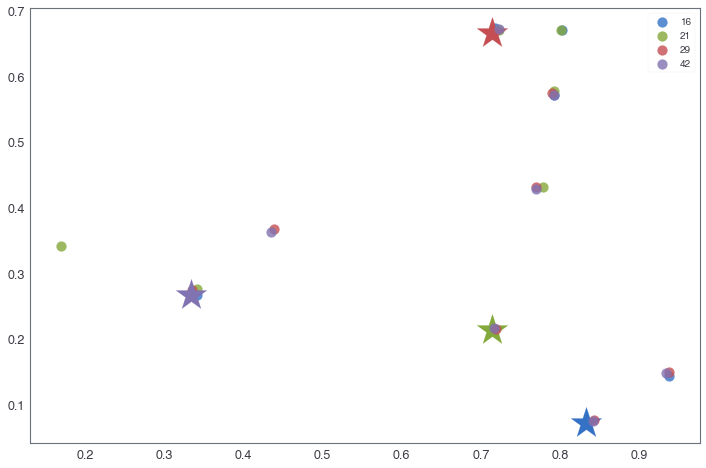

In [85]:

plt.figure(figsize=(12, 8))
subset_idx = all_probs.iloc[:100, :][(~all_probs.iloc[:100, :]['P(L, N, L)'].isna()) & (~all_probs.iloc[:100, :]['P(H, N, L)'].isna())].index
dist_thresh = 4
min_non_nan_points = 5
step = 200

for idx, i in tqdm.tqdm(enumerate(subset_idx)):
    base_benef = pilot_user_ids[indices[idx][0]]
    neigh_benefs = pilot_user_ids[indices[idx][1:]]
    nearest_n = len(distances[i][distances[idx]<dist_thresh])

#     if nearest_n < min_within_dist_count:
#         continue
    neigh_benefs = neigh_benefs[:nearest_n]
    neigh_trans_df = pilot_trans_df[pilot_trans_df.user_id.isin(neigh_benefs)]
    neigh_trans_df["user_id"] = base_benef

    base_trans_probs = all_probs[all_probs.user_id==base_benef][['P(L, N, L)', 'P(H, N, L)']]
    neigh_trans_probs = all_probs[all_probs.user_id.isin(neigh_benefs)][['P(L, N, L)', 'P(H, N, L)']]

    if pd.isna(base_trans_probs).values.sum():
        continue
    if (~neigh_trans_probs.iloc[:, 0].isna() & ~neigh_trans_probs.iloc[:, 1].isna()).sum() < min_non_nan_points:
        continue

    e = np.random.uniform(0, 0.01, neigh_trans_probs.shape)
    my_plot = plt.scatter(neigh_trans_probs.iloc[:, 0]+e[:, 0],
                neigh_trans_probs.iloc[:, 1]+e[:, 1],
               label=str(i), s=100, alpha=0.8)
    plt.scatter(base_trans_probs.values[0][0], base_trans_probs.values[0][1],
                marker='*', label='', alpha=1,
                color=my_plot.get_facecolors()[0], s=1050)
#     print('good')
plt.legend(fontsize=10)
plt.grid(b=None)


In [360]:

subset_idx = all_probs[(~all_probs['P(L, N, L)'].isna()) & (~all_probs['P(H, N, L)'].isna())].index

dist_thresh = 0.01
min_non_nan_points = 10
step = 10

for i in tqdm.tqdm(subset_idx[::step]):
    base_benef = pilot_user_ids[indices[i][0]]
    neigh_benefs = pilot_user_ids[indices[i][1:]]
    nearest_n = len(distances[i][distances[i]<dist_thresh])

#     if nearest_n < min_within_dist_count:
#         continue
    neigh_benefs = neigh_benefs[:nearest_n]
    neigh_trans_df = pilot_trans_df[pilot_trans_df.user_id.isin(neigh_benefs)]
    neigh_trans_df["user_id"] = base_benef

    base_trans_probs = all_probs[all_probs.user_id==base_benef][['P(L, N, L)', 'P(H, N, L)']]
    neigh_trans_probs = all_probs[all_probs.user_id.isin(neigh_benefs)][['P(L, N, L)', 'P(H, N, L)']]

    if pd.isna(base_trans_probs).values.sum():
        continue
    non_nan_points = (~neigh_trans_probs.iloc[:, 0].isna() & ~neigh_trans_probs.iloc[:, 1].isna())
    if non_nan_points.sum() < min_non_nan_points:
        continue

    e = np.random.uniform(0, 0.01, neigh_trans_probs.shape)
    std = neigh_trans_probs[non_nan_points].std().values
    mean = neigh_trans_probs[non_nan_points].mean().values
    print(f'neighbors mean: {mean}, std: {std} ')
    print('base: ', base_trans_probs.values )
    
    random_pts = all_probs[~all_probs[['P(L, N, L)', 'P(H, N, L)']].isna().\
                           sum(axis=1).astype(bool)].sample(1000)\
                          [['P(L, N, L)', 'P(H, N, L)']]
    std = random_pts.std().values
    mean = random_pts.mean().values
    print(f'random mean: {mean}, std: {std} \n')



  0%|          | 0/1016 [00:00<?, ?it/s]<ipython-input-360-f6282ee2fb10>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neigh_trans_df["user_id"] = base_benef
  5%|▍         | 46/1016 [00:00<00:06, 146.63it/s]

neighbors mean: [0.5553883  0.37951077], std: [0.22894433 0.18599745] 
base:  [[0.9        0.18181818]]
random mean: [0.67589609 0.36672481], std: [0.22694462 0.17313312] 



  9%|▉         | 89/1016 [00:00<00:06, 138.75it/s]

neighbors mean: [0.68651099 0.24375458], std: [0.15886342 0.14254026] 
base:  [[0.69230769 0.5       ]]
random mean: [0.67646659 0.35153   ], std: [0.22932418 0.16330548] 

neighbors mean: [0.60518778 0.33784752], std: [0.28579501 0.19058634] 
base:  [[0.85714286 0.42857143]]
random mean: [0.67959356 0.36087357], std: [0.22610731 0.16851045] 

neighbors mean: [0.67933039 0.28656312], std: [0.20130934 0.12841585] 
base:  [[0.85714286 0.07142857]]
random mean: [0.68034362 0.35312769], std: [0.21794996 0.16595701] 

neighbors mean: [0.57727273 0.37217631], std: [0.27742705 0.13183955] 
base:  [[0.8 0.4]]
random mean: [0.6732283  0.35699287], std: [0.22641045 0.17190401] 

neighbors mean: [0.49632035 0.37892562], std: [0.16065824 0.13322321] 
base:  [[0.2  0.25]]
random mean: [0.67858412 0.3621572 ], std: [0.2224689  0.16386338] 



 12%|█▏        | 119/1016 [00:00<00:06, 139.15it/s]

neighbors mean: [0.65400641 0.3245875 ], std: [0.25349994 0.19398402] 
base:  [[0.76923077 0.5       ]]
random mean: [0.67282903 0.36087491], std: [0.23112862 0.16496128] 

neighbors mean: [0.75413664 0.43460884], std: [0.1131474  0.24646267] 
base:  [[0.5        0.38461538]]
random mean: [0.67555419 0.35399039], std: [0.22611887 0.15801916] 

neighbors mean: [0.69353756 0.27812627], std: [0.18700032 0.13325047] 
base:  [[1.         0.14285714]]
random mean: [0.66935576 0.35113195], std: [0.23502523 0.16479257] 

neighbors mean: [0.67280329 0.3665183 ], std: [0.24980595 0.18433699] 
base:  [[0.84615385 0.25      ]]
random mean: [0.67473698 0.36043365], std: [0.22688059 0.16908644] 



 16%|█▌        | 163/1016 [00:01<00:06, 141.40it/s]

neighbors mean: [0.7571916  0.34666667], std: [0.21719343 0.11700254] 
base:  [[0.93333333 0.33333333]]
random mean: [0.68007508 0.35571329], std: [0.22897388 0.17010084] 

neighbors mean: [0.72398788 0.36212121], std: [0.17985863 0.17446291] 
base:  [[0.81818182 0.33333333]]
random mean: [0.67293365 0.36071518], std: [0.22749497 0.16864092] 

neighbors mean: [0.67842643 0.36256417], std: [0.21607954 0.15957452] 
base:  [[0.92307692 0.125     ]]
random mean: [0.67929144 0.36586015], std: [0.23116574 0.16772675] 



 19%|█▉        | 194/1016 [00:01<00:05, 138.76it/s]

neighbors mean: [0.67038438 0.39760032], std: [0.2621503  0.21358835] 
base:  [[0.66666667 0.44444444]]
random mean: [0.67022417 0.36095894], std: [0.22567691 0.16628005] 

neighbors mean: [0.59873963 0.363484  ], std: [0.2420493  0.19885529] 
base:  [[0.88888889 0.1       ]]
random mean: [0.68705363 0.35547442], std: [0.21770518 0.16641885] 

neighbors mean: [0.74594607 0.23834325], std: [0.18941458 0.112595  ] 
base:  [[0.66666667 0.33333333]]
random mean: [0.68284364 0.35824854], std: [0.21960761 0.16685599] 



 22%|██▏       | 224/1016 [00:01<00:05, 142.95it/s]

neighbors mean: [0.69255189 0.39457295], std: [0.15094449 0.21311766] 
base:  [[0.875 0.6  ]]
random mean: [0.68282037 0.36702918], std: [0.22405251 0.16612861] 



 27%|██▋       | 277/1016 [00:01<00:04, 156.61it/s]

neighbors mean: [0.74820208 0.36322324], std: [0.16188902 0.16427901] 
base:  [[0.66666667 0.13333333]]
random mean: [0.67335341 0.3504947 ], std: [0.22924289 0.16076143] 

neighbors mean: [0.66115721 0.32454891], std: [0.24748483 0.18104366] 
base:  [[0.625      0.23076923]]
random mean: [0.68642223 0.35973811], std: [0.22233047 0.17359705] 

neighbors mean: [0.56232864 0.35966664], std: [0.21285868 0.17879797] 
base:  [[0.90909091 0.125     ]]
random mean: [0.66341169 0.36739655], std: [0.23088885 0.16114982] 

neighbors mean: [0.6196173  0.43668531], std: [0.27126304 0.16194795] 
base:  [[0.5        0.45454545]]
random mean: [0.68496331 0.36044561], std: [0.217134   0.16364323] 

neighbors mean: [0.6777269  0.35029369], std: [0.24991113 0.1803954 ] 
base:  [[0.78571429 0.57142857]]
random mean: [0.67335225 0.3553151 ], std: [0.22501179 0.16704886] 

neighbors mean: [0.63616763 0.29402625], std: [0.2208383  0.16773124] 
base:  [[0.81818182 0.3       ]]
random mean: [0.66606754 0.3613

 31%|███▏      | 318/1016 [00:02<00:03, 176.22it/s]

neighbors mean: [0.61942724 0.3896374 ], std: [0.21248434 0.16345114] 
base:  [[0.625 0.25 ]]
random mean: [0.67029632 0.36160071], std: [0.23085412 0.16481722] 

neighbors mean: [0.65625922 0.38808543], std: [0.25337437 0.17635019] 
base:  [[0.2  0.25]]
random mean: [0.678755   0.36202425], std: [0.22926251 0.17096042] 

neighbors mean: [0.67133809 0.36056592], std: [0.24863884 0.18681972] 
base:  [[0.86666667 0.33333333]]
random mean: [0.67596305 0.36435651], std: [0.22751927 0.17226156] 

neighbors mean: [0.68875    0.29210956], std: [0.24616971 0.16905859] 
base:  [[0.63636364 0.4       ]]


 35%|███▌      | 357/1016 [00:02<00:03, 176.53it/s]

random mean: [0.67072506 0.3671188 ], std: [0.22635638 0.16718958] 

neighbors mean: [0.70059268 0.33453726], std: [0.22905804 0.13511808] 
base:  [[0.76923077 0.375     ]]
random mean: [0.68086445 0.35824463], std: [0.22586711 0.16867616] 

neighbors mean: [0.53464351 0.43902486], std: [0.28373333 0.2064038 ] 
base:  [[0.5        0.21428571]]
random mean: [0.68624288 0.36022389], std: [0.21768397 0.16948341] 

neighbors mean: [0.63066779 0.32295143], std: [0.23703795 0.19512917] 
base:  [[0.42857143 0.41666667]]
random mean: [0.67084915 0.35668168], std: [0.23201237 0.16581518] 

neighbors mean: [0.63826659 0.31473596], std: [0.26551115 0.14181935] 
base:  [[0.4    0.1875]]
random mean: [0.66793467 0.35981307], std: [0.22426907 0.17073274] 



 39%|███▊      | 393/1016 [00:02<00:03, 171.62it/s]

neighbors mean: [0.69721945 0.35724616], std: [0.20830331 0.12908403] 
base:  [[0.4 0.2]]
random mean: [0.67295106 0.36150979], std: [0.22683039 0.16434164] 

neighbors mean: [0.5511149  0.39305278], std: [0.22098972 0.18303028] 
base:  [[0.8 0.4]]
random mean: [0.67042605 0.36085874], std: [0.22521363 0.16861235] 

neighbors mean: [0.58098739 0.31450265], std: [0.19846465 0.129213  ] 
base:  [[0.4    0.1875]]
random mean: [0.69027678 0.36253644], std: [0.22041816 0.16986388] 



 42%|████▏     | 429/1016 [00:02<00:03, 172.24it/s]

neighbors mean: [0.79068075 0.38096655], std: [0.17935796 0.18727365] 
base:  [[0.71428571 0.21428571]]
random mean: [0.67311195 0.36784445], std: [0.21993625 0.17084131] 

neighbors mean: [0.68401131 0.32700582], std: [0.24246626 0.09849555] 
base:  [[0.44444444 0.41666667]]
random mean: [0.68604509 0.35013078], std: [0.2298853  0.17333466] 

neighbors mean: [0.57792446 0.40381741], std: [0.22270917 0.18861752] 
base:  [[0.5        0.36363636]]
random mean: [0.67278827 0.36074886], std: [0.22618437 0.16683606] 

neighbors mean: [0.48829365 0.37121212], std: [0.1969345  0.13266583] 
base:  [[0.6        0.36363636]]
random mean: [0.68200403 0.36861724], std: [0.22643765 0.16825928] 



 48%|████▊     | 484/1016 [00:03<00:03, 156.92it/s]

neighbors mean: [0.58810606 0.41980464], std: [0.24205393 0.22668522] 
base:  [[0.625      0.23076923]]
random mean: [0.6713546  0.35941149], std: [0.22797118 0.16074626] 

neighbors mean: [0.69255189 0.39457295], std: [0.15094449 0.21311766] 
base:  [[0.875 0.6  ]]
random mean: [0.68153025 0.34980507], std: [0.21990716 0.16451643] 

neighbors mean: [0.69287204 0.3746608 ], std: [0.16226912 0.17658986] 
base:  [[0.375      0.41666667]]
random mean: [0.68441146 0.35911193], std: [0.2229329  0.16770391] 

neighbors mean: [0.56753358 0.34829143], std: [0.22252284 0.1246162 ] 
base:  [[0.4    0.1875]]
random mean: [0.66682696 0.361295  ], std: [0.22871507 0.16420048] 

neighbors mean: [0.6468254  0.40340077], std: [0.2297377  0.15630169] 
base:  [[0.9375 0.4   ]]
random mean: [0.67446646 0.36119489], std: [0.22397413 0.16958914] 

neighbors mean: [0.64094025 0.42021842], std: [0.18640871 0.17298872] 
base:  [[0.4  0.25]]
random mean: [0.6745735  0.35591954], std: [0.23339756 0.16299526] 



 53%|█████▎    | 535/1016 [00:03<00:02, 162.50it/s]

neighbors mean: [0.59858003 0.3475012 ], std: [0.27894391 0.15164883] 
base:  [[1.  0.2]]
random mean: [0.67453133 0.35823991], std: [0.23139386 0.16807074] 

neighbors mean: [0.62483105 0.4366484 ], std: [0.21309687 0.19332909] 
base:  [[0.2        0.21428571]]
random mean: [0.67122559 0.36902643], std: [0.22662778 0.16941583] 

neighbors mean: [0.56791702 0.28586061], std: [0.25863814 0.11524619] 
base:  [[0.85714286 0.42857143]]
random mean: [0.66841004 0.36796349], std: [0.22811454 0.16815612] 

neighbors mean: [0.56090209 0.30237467], std: [0.29028046 0.11127357] 
base:  [[0.76923077 0.5       ]]
random mean: [0.68161783 0.36460355], std: [0.223093   0.16863254] 

neighbors mean: [0.73417996 0.35119048], std: [0.13943423 0.18818488] 
base:  [[0.93333333 0.33333333]]
random mean: [0.6796717  0.35363101], std: [0.22807965 0.16411702] 

neighbors mean: [0.70007689 0.33769992], std: [0.22573909 0.1673188 ] 
base:  [[0.83333333 0.25      ]]


 56%|█████▌    | 571/1016 [00:03<00:02, 168.72it/s]

random mean: [0.65967256 0.36219319], std: [0.22950409 0.16496892] 

neighbors mean: [0.50842188 0.35796287], std: [0.21958205 0.16913063] 
base:  [[0.85714286 0.42857143]]
random mean: [0.66273811 0.36146941], std: [0.23651283 0.16626278] 

neighbors mean: [0.69090745 0.39540043], std: [0.25210179 0.16521564] 
base:  [[0.85714286 0.42857143]]
random mean: [0.66558074 0.35760109], std: [0.23090848 0.16896212] 

neighbors mean: [0.68657705 0.32914282], std: [0.25484495 0.11145239] 
base:  [[0.66666667 0.44444444]]
random mean: [0.68220758 0.36050373], std: [0.22461085 0.16709239] 

neighbors mean: [0.63363095 0.39285714], std: [0.35866203 0.19269867] 
base:  [[0.6        0.13333333]]
random mean: [0.68059068 0.36736687], std: [0.22257934 0.16878068] 

neighbors mean: [0.5546492  0.32235841], std: [0.22777066 0.12700126] 
base:  [[0.33333333 0.26666667]]
random mean: [0.67605886 0.3618246 ], std: [0.22141372 0.17096514] 



 61%|██████▏   | 624/1016 [00:03<00:02, 163.35it/s]

neighbors mean: [0.6341847  0.39237078], std: [0.22675679 0.19395159] 
base:  [[0.66666667 0.5       ]]
random mean: [0.66696834 0.35805798], std: [0.23624929 0.16805857] 

neighbors mean: [0.64749385 0.43959994], std: [0.24650874 0.14105807] 
base:  [[0.8 0.5]]
random mean: [0.68596602 0.3560964 ], std: [0.22146314 0.16388707] 

neighbors mean: [0.72833545 0.34862926], std: [0.20672599 0.16057633] 
base:  [[0.86666667 0.5       ]]
random mean: [0.67459381 0.35883603], std: [0.22637615 0.16711048] 

neighbors mean: [0.72395999 0.36111335], std: [0.24546499 0.20554573] 
base:  [[0.8        0.33333333]]
random mean: [0.67603217 0.35667993], std: [0.2274059  0.16143486] 

neighbors mean: [0.70238095 0.3286963 ], std: [0.25856882 0.14758842] 
base:  [[0.84615385 0.375     ]]
random mean: [0.67613237 0.36459641], std: [0.22057326 0.16901538] 

neighbors mean: [0.63816669 0.39015371], std: [0.26886232 0.19348493] 
base:  [[0.875 0.6  ]]
random mean: [0.67876689 0.36060468], std: [0.22609897 

 65%|██████▍   | 659/1016 [00:04<00:02, 166.74it/s]

neighbors mean: [0.57434524 0.32164877], std: [0.25639135 0.08828219] 
base:  [[0.81818182 0.3       ]]
random mean: [0.68088696 0.36296197], std: [0.22466518 0.16818412] 

neighbors mean: [0.63090946 0.34277207], std: [0.2039495  0.17164281] 
base:  [[0.28571429 0.35714286]]
random mean: [0.68032231 0.34966956], std: [0.22605445 0.16518864] 

neighbors mean: [0.71097583 0.3411526 ], std: [0.24367187 0.12546053] 
base:  [[0.4  0.25]]
random mean: [0.67303759 0.35753614], std: [0.22829693 0.16212406] 

neighbors mean: [0.41019557 0.38487367], std: [0.2341189  0.08901347] 
base:  [[0.8        0.13333333]]
random mean: [0.68388371 0.36981454], std: [0.22185892 0.16678152] 

neighbors mean: [0.76559917 0.32310606], std: [0.18259641 0.14723568] 
base:  [[0.83333333 0.06666667]]
random mean: [0.67122461 0.36668   ], std: [0.22369663 0.17427742] 

neighbors mean: [0.63510006 0.36684756], std: [0.21970494 0.14830785] 
base:  [[0.69230769 0.625     ]]
random mean: [0.67869931 0.35301823], std: 

 68%|██████▊   | 695/1016 [00:04<00:02, 152.83it/s]

neighbors mean: [0.44325397 0.3587013 ], std: [0.18380028 0.13063758] 
base:  [[0.57142857 0.28571429]]
random mean: [0.68250227 0.35827401], std: [0.22287299 0.1684846 ] 

neighbors mean: [0.52839168 0.33598775], std: [0.2762539  0.09271004] 
base:  [[0.33333333 0.26666667]]
random mean: [0.68145507 0.35774258], std: [0.22328038 0.16571182] 

neighbors mean: [0.51948413 0.29672161], std: [0.22534391 0.12470292] 
base:  [[0.66666667 0.55555556]]
random mean: [0.68273541 0.35639967], std: [0.2252712  0.16734923] 

neighbors mean: [0.68477911 0.33874181], std: [0.20062128 0.13383381] 
base:  [[0.83333333 0.22222222]]
random mean: [0.68761503 0.35768451], std: [0.21758033 0.17180122] 

neighbors mean: [0.52357895 0.36819134], std: [0.27065579 0.11939338] 
base:  [[0.78571429 0.42857143]]
random mean: [0.6826647  0.36709776], std: [0.22607422 0.16553586] 

neighbors mean: [0.60044433 0.3535141 ], std: [0.23694454 0.11637598] 
base:  [[0.75  0.375]]
random mean: [0.67945971 0.36303291], std

 73%|███████▎  | 744/1016 [00:04<00:01, 155.47it/s]

neighbors mean: [0.80588805 0.35959596], std: [0.15760717 0.19711527] 
base:  [[0.93333333 0.33333333]]
random mean: [0.67062577 0.35817742], std: [0.2308744  0.16752949] 

neighbors mean: [0.70857143 0.30452922], std: [0.15621813 0.1138963 ] 
base:  [[0.9375 0.4   ]]
random mean: [0.67855904 0.35887432], std: [0.22520427 0.16365348] 

neighbors mean: [0.71813041 0.40308362], std: [0.22479148 0.18299959] 
base:  [[0.8125 0.6   ]]
random mean: [0.67594833 0.36291062], std: [0.23280885 0.16771029] 

neighbors mean: [0.60935065 0.24737637], std: [0.30832768 0.09473521] 
base:  [[1.  0.2]]
random mean: [0.67869505 0.35876088], std: [0.22925772 0.16589145] 

neighbors mean: [0.72254579 0.42622114], std: [0.20550282 0.24979612] 
base:  [[0.75       0.33333333]]
random mean: [0.677826   0.36589344], std: [0.22360285 0.16325985] 

neighbors mean: [0.66999795 0.39413781], std: [0.19537521 0.14469955] 
base:  [[0.71428571 0.57142857]]
random mean: [0.67903692 0.35687305], std: [0.22650535 0.1681

 76%|███████▋  | 777/1016 [00:04<00:01, 149.81it/s]

neighbors mean: [0.79413291 0.41665589], std: [0.16221906 0.18155592] 
base:  [[0.86666667 0.5       ]]
random mean: [0.67583147 0.36137599], std: [0.22386805 0.16827145] 

neighbors mean: [0.67396492 0.37265501], std: [0.1493891  0.13819848] 
base:  [[0.2        0.26666667]]
random mean: [0.67747846 0.35528753], std: [0.23002243 0.16814752] 

neighbors mean: [0.80492159 0.25341578], std: [0.17321411 0.14628263] 
base:  [[0.86666667 0.5       ]]
random mean: [0.67144603 0.36447233], std: [0.22953036 0.16768689] 

neighbors mean: [0.5796875 0.3343319], std: [0.29993392 0.12776836] 
base:  [[0.9375 0.4   ]]
random mean: [0.67386517 0.36659443], std: [0.22853261 0.16885984] 

neighbors mean: [0.70428622 0.34423094], std: [0.20009662 0.17085349] 
base:  [[0.76923077 0.5       ]]
random mean: [0.6840862  0.35649916], std: [0.23138232 0.16527651] 

neighbors mean: [0.63090946 0.34277207], std: [0.2039495  0.17164281] 
base:  [[0.28571429 0.35714286]]
random mean: [0.66894719 0.3534105 ], std

 78%|███████▊  | 793/1016 [00:05<00:01, 142.45it/s]

neighbors mean: [0.56765387 0.35368567], std: [0.26952406 0.13563487] 
base:  [[0.9375 0.4   ]]
random mean: [0.68004216 0.36093574], std: [0.22717676 0.16854765] 

neighbors mean: [0.66276489 0.32664455], std: [0.19925166 0.12742158] 
base:  [[0.63636364 0.4       ]]
random mean: [0.67407856 0.35718571], std: [0.23160931 0.17093706] 

neighbors mean: [0.65724009 0.36330009], std: [0.1788929  0.14133874] 
base:  [[0.57142857 0.30769231]]
random mean: [0.68240676 0.3647683 ], std: [0.22042753 0.16937321] 

neighbors mean: [0.66723021 0.36712017], std: [0.25225026 0.18067378] 
base:  [[1.  0.2]]
random mean: [0.67590062 0.3649346 ], std: [0.22592193 0.16651194] 

neighbors mean: [0.73261583 0.34215376], std: [0.21775504 0.10757041] 
base:  [[0.92857143 0.28571429]]
random mean: [0.67799904 0.35554136], std: [0.22335159 0.16700672] 

neighbors mean: [0.63357753 0.34529165], std: [0.17797526 0.16343599] 
base:  [[0.8 0.5]]


 81%|████████  | 822/1016 [00:05<00:01, 136.49it/s]

random mean: [0.67268123 0.35872284], std: [0.23984038 0.16796759] 

neighbors mean: [0.48074249 0.33390568], std: [0.28110057 0.11358121] 
base:  [[0.875 0.4  ]]
random mean: [0.67799681 0.36614798], std: [0.2251226  0.17038849] 

neighbors mean: [0.59841611 0.33313572], std: [0.21631419 0.1219465 ] 
base:  [[0.69230769 0.5       ]]
random mean: [0.67152907 0.3594857 ], std: [0.22934252 0.16604415] 

neighbors mean: [0.69833123 0.28597956], std: [0.18917575 0.14829783] 
base:  [[0.7 0.2]]
random mean: [0.68083004 0.34850287], std: [0.22576842 0.16152793] 

neighbors mean: [0.54975778 0.34571064], std: [0.29071508 0.10738134] 
base:  [[0.85714286 0.42857143]]
random mean: [0.67495856 0.35323832], std: [0.23174633 0.16600357] 

neighbors mean: [0.5326633  0.36595469], std: [0.27140569 0.12733654] 
base:  [[1.  0.2]]
random mean: [0.67889163 0.35824285], std: [0.22302648 0.16772715] 

neighbors mean: [0.76163605 0.34262626], std: [0.21142937 0.08363751] 
base:  [[1.         0.11111111]]


 87%|████████▋ | 887/1016 [00:05<00:00, 152.15it/s]

neighbors mean: [0.69072751 0.31444833], std: [0.23718861 0.16905641] 
base:  [[0.2  0.25]]
random mean: [0.67377626 0.36210132], std: [0.22336971 0.16950499] 

neighbors mean: [0.6606129  0.39229986], std: [0.18443827 0.15208   ] 
base:  [[0.63636364 0.33333333]]
random mean: [0.67641733 0.35712874], std: [0.22360486 0.16196767] 

neighbors mean: [0.73779623 0.36152146], std: [0.19426639 0.17432377] 
base:  [[0.75       0.44444444]]
random mean: [0.69026839 0.35759024], std: [0.22599095 0.16250365] 

neighbors mean: [0.63090946 0.34277207], std: [0.2039495  0.17164281] 
base:  [[0.28571429 0.35714286]]
random mean: [0.67614055 0.3544949 ], std: [0.22954885 0.16191931] 

neighbors mean: [0.64749385 0.43959994], std: [0.24650874 0.14105807] 
base:  [[0.8 0.5]]
random mean: [0.68250357 0.35596834], std: [0.21963194 0.16462389] 



 91%|█████████ | 923/1016 [00:05<00:00, 161.44it/s]

neighbors mean: [0.77772228 0.36408743], std: [0.10622355 0.21073911] 
base:  [[1.  0.2]]
random mean: [0.67699386 0.36086406], std: [0.22288399 0.16743266] 

neighbors mean: [0.67399972 0.42471567], std: [0.19504346 0.18508235] 
base:  [[0.5        0.45454545]]
random mean: [0.68437546 0.35671212], std: [0.22699576 0.16607938] 

neighbors mean: [0.57229548 0.35667888], std: [0.22008764 0.13921749] 
base:  [[0.42857143 0.35714286]]
random mean: [0.67361021 0.36069991], std: [0.23479848 0.17173397] 

neighbors mean: [0.6093254  0.37569283], std: [0.20689132 0.1706115 ] 
base:  [[0.93333333 0.33333333]]
random mean: [0.67907457 0.36161212], std: [0.22628104 0.16772349] 

neighbors mean: [0.62479786 0.40144578], std: [0.21234021 0.13907935] 
base:  [[0.85714286 0.07142857]]
random mean: [0.67302085 0.35342692], std: [0.23032627 0.16489853] 



 95%|█████████▍| 962/1016 [00:06<00:00, 165.40it/s]

neighbors mean: [0.69897453 0.27169977], std: [0.28298441 0.13888135] 
base:  [[0.33333333 0.26666667]]
random mean: [0.66922342 0.35571158], std: [0.22629293 0.16987943] 

neighbors mean: [0.56642716 0.31774892], std: [0.19111197 0.12637953] 
base:  [[0.8        0.18181818]]
random mean: [0.66652286 0.3690031 ], std: [0.23024998 0.16831   ] 



 98%|█████████▊| 995/1016 [00:06<00:00, 145.74it/s]

neighbors mean: [0.73247475 0.29950087], std: [0.18444089 0.17708945] 
base:  [[0.42857143 0.35714286]]
random mean: [0.69284016 0.35873642], std: [0.21824413 0.1617554 ] 

neighbors mean: [0.69693106 0.36511181], std: [0.15136883 0.17899149] 
base:  [[0.8        0.27272727]]
random mean: [0.66742984 0.35824353], std: [0.23521287 0.16901056] 

neighbors mean: [0.64892459 0.36849034], std: [0.18005849 0.13036388] 
base:  [[0.8        0.66666667]]
random mean: [0.66841784 0.37312745], std: [0.22717988 0.17646096] 



100%|██████████| 1016/1016 [00:06<00:00, 155.73it/s]

neighbors mean: [0.68230769 0.26253788], std: [0.25042429 0.09754284] 
base:  [[1.         0.09090909]]
random mean: [0.67226764 0.35677141], std: [0.22653105 0.16530644] 

neighbors mean: [0.67099741 0.39097881], std: [0.30335605 0.13184005] 
base:  [[0.33333333 0.5       ]]
random mean: [0.67030086 0.35941253], std: [0.23830823 0.16793442] 



In [349]:
all_probs[['P(L, N, L)', 'P(H, N, L)']].isna().sum(axis=1).astype(bool).sample(5)

8249      True
6755      True
14643     True
19288    False
2806      True
dtype: bool

In [350]:
non_nan_points

9464    False
dtype: bool

In [361]:
!pip install gower

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=c7d61bdcca81847a1b7bf32073de2e25514ee173197847f1c549669798994c3c
  Stored in directory: /Users/vermashresth/Library/Caches/pip/wheels/0e/4a/62/f296d39ee4f9ffc44a8d44413dc8ce99ed022c581352312c20
Successfully built gower


In [480]:
import pandas as pd
import numpy as np
from sklearn.neighbors import DistanceMetric


def gower_distance(X):
    """
    This function expects a pandas dataframe as input
    The data frame is to contain the features along the columns. Based on these features a
    distance matrix will be returned which will contain the pairwise gower distance between the rows
    All variables of object type will be treated as nominal variables and the others will be treated as 
    numeric variables.
    Distance metrics used for:
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes.iloc[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / max(np.ptp(feature.values),1)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

In [51]:
Xd

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-6.579494,0.0,1.0,0.0,0.0,0.0,0.0,-5.762257,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-12.579494,0.0,1.0,0.0,0.0,0.0,0.0,-5.762257,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-9.579494,0.0,2.0,1.0,0.0,1.0,0.0,-5.762257,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10.420506,0.0,3.0,2.0,0.0,2.0,0.0,-5.762257,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-10.579494,0.0,2.0,1.0,0.0,1.0,0.0,-5.762257,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-5.579494,1.0,5.0,5.0,0.0,5.0,0.0,-5.762257,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
296,-11.579494,0.0,1.0,0.0,0.0,0.0,0.0,-4.762257,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
297,-13.579494,1.0,2.0,1.0,0.0,1.0,0.0,-5.762257,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
298,-3.579494,0.0,1.0,0.0,0.0,0.0,0.0,-4.762257,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
def gower_dist_func(x, y, **kwargs):
    dist = 0
#     print(x)
#     print(kwargs['ranges'])
    for i in range(len(x)):
        if kwargs['is_cat_vector'][i]:
            if x[i]==y[i]:
                feature_dist = 0
            else:
                feature_dist = 1
        else:
                feature_dist = np.abs(x[i]-y[i]) / kwargs['ranges'][i]
        dist+=feature_dist
    return dist

In [65]:
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import normalize

from sklearn.neighbors import NearestNeighbors
import numpy as np

cat_bool = np.ones(pilot_static_features.shape[1]).astype(bool)
cat_bool[[0, 2, 3, 4, 5, 6, 7]] = False

Xd = pd.DataFrame(pilot_static_features[:100])

ranges = np.ptp(pilot_static_features, axis=0)
nbrs = NearestNeighbors(n_neighbors=30, metric=gower_dist_func,
                        metric_params={
                                      "ranges":ranges,
                                      "is_cat_vector":cat_bool}).\
                        fit(Xd.values)
distances, indices = nbrs.kneighbors(Xd.values)
indices
# distances, indices = nbrs.kneighbors(gower_distance(Xd))

array([[ 0, 96, 29, ..., 55, 89, 88],
       [ 1, 35, 40, ..., 90, 29,  9],
       [ 2, 81,  4, ..., 38,  8, 99],
       ...,
       [97, 91, 37, ..., 65, 29, 55],
       [98, 87, 14, ...,  0, 96, 22],
       [99, 13, 17, ..., 50, 66, 68]])

In [61]:
np.ptp(pilot_static_features, axis=0)

array([39.        ,  1.        ,  6.        ,  6.        ,  2.        ,
        6.        ,  3.        , 93.00000381,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ])

In [26]:
gower_dist_func([1,2,3], [0, 5, 1], ranges=[1, 4, 4], is_cat_vector = [1, 0, 0])

2.25

In [39]:
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import normalize

from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=4, metric=gower_dist_func,
                        metric_params={
                                      "ranges":[1, 4, 4],
                                      "is_cat_vector":[1, 0, 0]}).\
                        fit(np.array([[1,2,3],
                                      [0, 5, 1],
                                     [0, 3, 3],
                                     [0, 4, 1],
                                     [1, 2, 4]]))
distances, indices = nbrs.kneighbors(np.array([[1,2,3], [0, 5, 1]]))
indices
# distances, indices = nbrs.kneighbors(gower_distance(Xd))


array([[0, 4, 2, 3],
       [1, 3, 2, 0]])

In [469]:
# nbrs = NearestNeighbors(n_neighbors=40, algorithm='ball_tree', metric='precomputed')  
# distances, indices = nbrs.kneighbors(gower_distance(Xd))


In [482]:
# import sklearn
# import pandas as pd
# import numpy as np
# from sklearn.neighbors import DistanceMetric


# def gower_distance(X, Y):
#     """
#     This function expects a pandas dataframe as input
#     The data frame is to contain the features along the columns. Based on these features a
#     distance matrix will be returned which will contain the pairwise gower distance between the rows
#     All variables of object type will be treated as nominal variables and the others will be treated as 
#     numeric variables.
#     Distance metrics used for:
#     Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
#     Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
#     """
#     print(type(X), type(Y))
#     individual_variable_distances = []

#     for i in range(X.shape[1]):
#         feature = X.iloc[:,[i]]
#         if feature.dtypes.iloc[0] == np.object:
#             feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
#         else:
#             feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / max(np.ptp(feature.values),1)

#         individual_variable_distances.append(feature_dist)

#     return np.array(individual_variable_distances).mean(0)
# nbrs = NearestNeighbors(n_neighbors=40,
#                         metric='precomputed', metric_params={"func":gower_distance}).fit(Xd)   
# distances, indices = nbrs.kneighbors(Xd)


In [484]:
nbrs = NearestNeighbors(n_neighbors=40, metric='precomputed').fit(gower_distance(Xd)))
# distances, indices = nbrs.kneighbors(


SyntaxError: unmatched ')' (<ipython-input-484-b92e41ff8062>, line 1)